 ALS FUNKTION SCHREIBEN !!!

 EIN MODUL MIT ALLEN FUNKTIONEN, UND DIE DANN CALLEN IM EIGENTLICHEN NOTEBOOK !!!

 SINGLE UND MARRIED IN EINEM PLOT SEHEN !!! BESSER VERGLEICHBAR !!!

**Hier eine Beschreibung hin.** 

- Wie ist der Datensatz aufgebaut? 
- Was ist in den einzelnen Kapiteln zu finden? 
- An welchen Stellen im Code muss ich Variablen und Parameter definieren? 


# Load Packages

In [1]:
#### Load Packages

import pandas as pd 
import numpy as np
import math 
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.iolib.summary2 import summary_col
from statsmodels.api import OLS
import seaborn as sns
from rfpimp import plot_corr_heatmap
from rfpimp import permutation_importances
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.base import clone
from itertools import repeat
import probscale
from IPython.display import display_html
from scipy.stats import spearmanr
from scipy.stats import pearsonr

%matplotlib inline
sns.set_style('whitegrid');
sns.set(rc = {'figure.figsize': (18.5,15.5)});
plt.figure(figsize=(18.5,15.5));
pd.set_option('display.max_columns', None)

C:\Users\User\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed i

<Figure size 1332x1116 with 0 Axes>

# Define Variables and Parameters

In [2]:
#### Define the key variables

## Income Variable
income_var = 'tpearn'
income_var_mean = 'tpearn_mean'
initial_dataset = 'Cleaned_Data_Individual.csv'
lag = 'All'



#### Set parameters for household selection
exclude_zero_labor_income = True # True excludes households with 0 labor income from the following analysis
exclusion_percentile = [5,95] # excludes upper and lower percentiles of the income distribution
upper_income_bound = None 
lower_income_bound = None
max_ratio = 1.5# maximum ratio between monthly reported labor income and average labor income over 8 month
                # households with ratio values higher than the parameter set or lower than 1 divided by the parameter set 
                # will be excluded
rebate_only = False # if True, then households with no rebate payment in the dataset will be excluded from the analysis
                    # if False, then households with no rebate payment in the dataset will be in the control group exclusively
                    # code for this exclusion option is in the section 'Uplifting'
        
rebate_observable = False # if True, then households are excluded if their rebate reception months is prior to their first observation months
        
max_famsize = 6 # select the maximum famsize for my calculation

    
######################################################################################################################


#### Set parameters for random forest algorithms
n_est = 10000
r_s = 0
m_d = 5
feat = 'sqrt'
oob_score = True
bootstrap = True

# Functions

In [3]:
############################################################################################################

## Functions for Displaying several DataFrames below each other

############################################################################################################


def display_below_each_other(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:block"'),raw=True)


############################################################################################################

## Functions for the Feature Importance Section

############################################################################################################




# Create a feature importance dataframe for the default computation
def imp_df(feature_names_model_1, feature_names_model_2, model_1, model_2, name_model_1, name_model_2):
    
    if len(feature_names_model_1) != len(feature_names_model_2): 
    
        df1 = pd.DataFrame({'Feature': feature_names_model_1, 
                       str(name_model_1) + ' feature importance': model_1.feature_importances_})
        df2 = pd.DataFrame({'Feature': feature_names_model_2, 
                       str(name_model_2) + ' feature importance': model_2.feature_importances_})
        df = pd.concat([df1,df2], ignore_index=True, axis=1)
        df.columns = ['a','b','c','d']
        df.drop('a', axis = 1)
        df = df[['c','b','d']]
        df.columns = ['Feature', str(name_model_1) + ' feature importance', str(name_model_2) + ' feature importance']
        df = df.sort_values(str(name_model_1) + ' feature importance', ascending = False).reset_index(drop = True)
        
        
    else: 
        df  = pd.DataFrame({'Feature': feature_names_model_1, 
                       str(name_model_1) + ' feature importance': model_1.feature_importances_, 
                       str(name_model_2) + ' feature importance': model_2.feature_importances_}) \
                    .sort_values(str(name_model_1) + ' feature importance', ascending = False) \
                    .reset_index(drop = True)
    
    
    return df




############################################################################################################


# Create a feature importance plot for the default computation
def feat_imp_plot(df, name_model_1, name_model_2, title):

    sns.set()
    sns.set(font_scale=1.3)
    sns.set_style("whitegrid")
    
    # importances are already sorted correctly
    importances_1 = df[str(name_model_1) +  ' feature importance']    
    importances_2 = df[str(name_model_2) +  ' feature importance']    

    names = df['Feature']                            
    group_1 = [name_model_1] * len(names)                  
    group_2 = [name_model_2] * len(names)

    data = {'feature_importance': importances_1, 'feature_name': names, 'Data Set': group_1}
    df = pd.DataFrame(data)
    data2 = {'feature_importance': importances_2, 'feature_name': names, 'Data Set': group_2}
    df2 = pd.DataFrame(data2)
    df = df.append(df2, ignore_index = True)
    df = df.sort_values(['Data Set', 'feature_importance'], ascending = (True, False))
    
    
    pl = sns.catplot(x='feature_importance', y='feature_name', hue='Data Set', data=df, orient = 'h',
                height=6, aspect=2, kind='bar', palette='Set1', linewidth = 0.3, legend_out=False)
    pl.set_ylabels('Feature Name', fontsize = 20)
    pl.set_xlabels('Feature Importance', fontsize = 20)
    plt.xticks(rotation=0, horizontalalignment='right')


    
    
############################################################################################################


# Create a feature importance dataframe for the permutation computation
def perm_imp_rfpimp_df(feature_names_model_1, feature_names_model_2, model_1, model_2, name_model_1, name_model_2):
    
    
    control_perm_imp_rfpimp = permutation_importances(model_1, rf_control_features, 
                                                      labels, control_r2)
    control_perm_imp_rfpimp.reset_index(drop = False, inplace = True)
    
    
    treatment_perm_imp_rfpimp = permutation_importances(model_2, rf_treatment_features, 
                                                        labels, treatment_r2)
    treatment_perm_imp_rfpimp.reset_index(drop = False, inplace = True)
    
    
    if len(feature_names_model_1) != len(feature_names_model_2):  
    
        df1 = pd.DataFrame(data = control_perm_imp_rfpimp)
        df2 = pd.DataFrame(data = treatment_perm_imp_rfpimp)
    
        df = df1.merge(df2, on = 'Feature')
    
        df.append(df2)
    
        df3 = pd.DataFrame([['rebate_uplifting', np.nan, df2.iloc[len(df1),1]], ['rebate_uplifting_spend', np.nan, df2.iloc[len(df1)+1,1]], 
                      ['rebate_uplifting_save', np.nan, df2.iloc[len(df1)+2,1]], ['rebate_uplifting_debt', np.nan, df2.iloc[len(df1)+3,1]]], 
                       columns=list(['Feature', 'Importance_x', 'Importance_y']))

        df = df.append(df3, ignore_index = True)

        df.rename(columns={'Importance_x': str(name_model_1) +  ' feature importance', 
                       'Importance_y': str(name_model_2) +  ' feature importance'}, inplace = True)
        
        
    else: 
          
        df1 = pd.DataFrame(data = control_perm_imp_rfpimp)
        df2 = pd.DataFrame(data = treatment_perm_imp_rfpimp)
    
        df = df1.merge(df2, on = 'Feature')


        df.rename(columns={'Importance_x': str(name_model_1) +  ' feature importance', 
                       'Importance_y': str(name_model_2) +  ' feature importance'}, inplace = True)
    
    return df



    

############################################################################################################


# Create a feature importance dataframe for the permutation computation
def perm_imp_eli5_df(feature_names_model_1, feature_names_model_2, model_1, model_2, name_model_1, name_model_2):
    
    control_perm = PermutationImportance(model_1, cv = None, refit = False, n_iter = 2). \
                                                    fit(rf_control_features, labels)
    
    treatment_perm = PermutationImportance(model_2, cv = None, refit = False, n_iter = 2). \
                                                    fit(rf_treatment_features, labels)
    

    
    if len(feature_names_model_1) != len(feature_names_model_2):
        
        df1 = pd.DataFrame({'Feature': feature_names_model_1, 
                       str(name_model_1) + ' feature importance': control_perm.feature_importances_})
        df2 = pd.DataFrame({'Feature': feature_names_model_2, 
                       str(name_model_2) + ' feature importance': treatment_perm.feature_importances_})
        df = pd.concat([df1,df2], ignore_index=True, axis=1)
        df.columns = ['a','b','c','d']
        df.drop('a', axis = 1)
        df = df[['c','b','d']]
        df.columns = ['Feature', str(name_model_1) + ' feature importance', str(name_model_2) + ' feature importance']
        df = df.sort_values(str(name_model_1) + ' feature importance', ascending = False).reset_index(drop = True)
    
    
    
    else: 
        
        df = pd.DataFrame({'Feature': feature_names_model_1, 
                      str(name_model_1) + ' feature importance': control_perm.feature_importances_, 
                      str(name_model_2) + ' feature importance': treatment_perm.feature_importances_}) \
           .sort_values(str(name_model_1) + ' feature importance', ascending = False) \
           .reset_index(drop = True)
    
    return df    





############################################################################################################


# Define the calculation of the R2 score for the permutation feature importance

def control_r2(model_1, rf_control_train_features, control_train_labels): 
    return r2_score(control_train_labels, model_1.predict(rf_control_train_features))


def treatment_r2(model_2, rf_treatment_train_features, treatment_train_labels): 
    return r2_score(treatment_train_labels, model_2.predict(rf_treatment_train_features))




############################################################################################################




def drop_col_feat_imp(feature_names_model_1, feature_names_model_2, model_1, model_2):
    
    model_1_clone = clone(model_1)
    model_2_clone = clone(model_2)
    
    model_1_clone.random_state = random_state
    model_2_clone.random_state = random_state
    
    model_1_clone.fit(rf_control_features, labels)
    model_2_clone.fit(rf_treatment_features, labels)  
    
    benchmark_1_score = model_1_clone.score(rf_control_features, labels)
    benchmark_2_score = model_2_clone.score(rf_treatment_features, labels)
    
    importances_1 = []
    importances_2 = []

    for x in rf_control_train_features.columns:
        model_1_clone = clone(model_1)
        model_1_clone.random_state = random_state
        model_1_clone.fit(rf_control_features.drop(x,axis = 1), labels)
        drop_x_1_score = model_1_clone.score(rf_control_features.drop(x,axis = 1), labels)
        importances_1.append(benchmark_1_score - drop_x_1_score)
        
    for y in rf_treatment_train_features.columns:
        model_2_clone = clone(model_2)
        model_2_clone.random_state = random_state
        model_2_clone.fit(rf_treatment_features.drop(y,axis = 1), labels)
        drop_y_2_score = model_2_clone.score(rf_treatment_features.drop(y,axis = 1), labels)
        importances_2.append(benchmark_2_score - drop_y_2_score)
        
    
    if len(feature_names_model_1) != len(feature_names_model_2):
    
        df1 = pd.DataFrame({'Feature': feature_names_model_1, 
                       str(name_model_1) + ' feature importance': importances_1})
        df2 = pd.DataFrame({'Feature': feature_names_model_2, 
                       str(name_model_2) + ' feature importance': importances_2})
        result_df = pd.concat([df1,df2], ignore_index=True, axis=1)
        result_df.columns = ['a','b','c','d']
        result_df.drop('a', axis = 1)
        result_df = result_df[['c','b','d']]
        result_df.columns = ['Feature', str(name_model_1) + ' feature importance', str(name_model_2) + ' feature importance']
        result_df = result_df.sort_values(str(name_model_1) + ' feature importance', ascending = False).reset_index(drop = True)
    
    else: 
        result_df = pd.DataFrame({'Feature': feature_names_model_1, 
                      str(name_model_1) + ' feature importance': importances_1, 
                      str(name_model_2) + ' feature importance': importances_2}) \
           .sort_values(str(name_model_1) + ' feature importance', ascending = False) \
           .reset_index(drop = True)
    
    
    
    
    
    return result_df




############################################################################################################

## Functions for the Partial Dependence Section

## Compared to the Final Code Household Data File, I do not have to adjust the plots, since I only focus on
## rebate months in the analysis. For rebate months, this version of the PDPs works perfectly well.

############################################################################################################


def pdp_df(model_1, model_2, X_1, X_2, feature_pred, pd_feature, kind):

    X_temp_1 = X_1.copy()
    X_temp_2 = X_2.copy()


    grid = np.unique(X_temp_2[:, pd_feature])
    
    
    y_diff_mean = np.zeros(len(grid))
    y_diff_median = np.zeros(len(grid))
    y_diff_perc_5 = np.zeros(len(grid))
    y_diff_perc_25 = np.zeros(len(grid))    
    y_diff_perc_75 = np.zeros(len(grid))
    y_diff_perc_95 = np.zeros(len(grid))    
    y_diff_sd = np.zeros(len(grid))
    
    if kind == 'Absolute': 
        unit = 'USD'
    else: 
        unit = '%'
    

    for i, value in enumerate(grid):
        
        if pd_feature in rf_control_features_list == True: 
            X_temp_1[:, pd_feature] = value
            data_1 = X_temp_1
        else: 
            data_1 = X_temp_1
            
        X_temp_2[:, pd_feature] = value
        data_2 = X_temp_2

            
        pred_1 = model_1.predict(data_1) # control predictions
        pred_2 = model_2.predict(data_2) # treatment predictions
        
        diffs = pred_2 - pred_1 
        
        if kind == 'Absolute':
        
            y_diff_mean[i] = np.mean(diffs)
            y_diff_median[i] = np.median(diffs)
            y_diff_perc_5[i] = np.percentile(diffs, 5)
            y_diff_perc_25[i] = np.percentile(diffs, 25)
            y_diff_perc_75[i] = np.percentile(diffs, 75)
            y_diff_perc_95[i] = np.percentile(diffs, 95)
            y_diff_sd[i] = np.std(diffs)
        
        elif kind == 'Percentual':
            
            y_diff_mean[i] = np.mean(diffs/selected_lags[income_var])#*100
            y_diff_median[i] = np.median(diffs/selected_lags[income_var])#*100
            y_diff_perc_5[i] = np.percentile(diffs/selected_lags[income_var], 5)#*100
            y_diff_perc_25[i] = np.percentile(diffs/selected_lags[income_var], 25)#*100
            y_diff_perc_75[i] = np.percentile(diffs/selected_lags[income_var], 75)#*100
            y_diff_perc_95[i] = np.percentile(diffs/selected_lags[income_var], 95)#*100
            y_diff_sd[i] = np.std(diffs/selected_lags[income_var])#*100
            
        else: 
            
            y_diff_mean[i] = np.mean(diffs/selected_lags.reb_size)#*100
            y_diff_median[i] = np.median(diffs/selected_lags.reb_size)#*100
            y_diff_perc_5[i] = np.percentile(diffs/selected_lags.reb_size, 5)#*100
            y_diff_perc_25[i] = np.percentile(diffs/selected_lags.reb_size, 25)#*100
            y_diff_perc_75[i] = np.percentile(diffs/selected_lags.reb_size, 75)#*100
            y_diff_perc_95[i] = np.percentile(diffs/selected_lags.reb_size, 95)#*100
            y_diff_sd[i] = np.std(diffs/selected_lags.reb_size)#*100
            
     
    
    
    result_table = pd.DataFrame({chosen_feature: grid,
                            'Mean '+str(kind)+' Difference': y_diff_mean, 
                            'Median '+str(kind)+' Difference': y_diff_median, 
                            '5th Percentile '+str(kind)+' Difference': y_diff_perc_5,     
                            '25th Percentile '+str(kind)+' Difference': y_diff_perc_25,
                            '75th Percentile '+str(kind)+' Difference': y_diff_perc_75,
                            '95th Percentile '+str(kind)+' Difference': y_diff_perc_95,                                 
                            'Standard Deviation '+str(kind)+' Difference': y_diff_sd}).set_index(chosen_feature)

    return result_table



############################################################################################################

## PDP for monthly working hour changes



def pdp_hour_df(model_1, model_2, X_1, X_2, feature_pred, pd_feature, kind):

    X_temp_1 = X_1.copy()
    X_temp_2 = X_2.copy()


    grid = np.unique(X_temp_2[:, pd_feature])
    
    
    hours_diff_mean = np.zeros(len(grid))
    hours_diff_median = np.zeros(len(grid))
    

    for i, value in enumerate(grid):
        
        if pd_feature in rf_control_features_list == True: 
            X_temp_1[:, pd_feature] = value
            data_1 = X_temp_1
        else: 
            data_1 = X_temp_1
            
        X_temp_2[:, pd_feature] = value
        data_2 = X_temp_2

            
        pred_1 = model_1.predict(data_1) # control predictions
        pred_2 = model_2.predict(data_2) # treatment predictions
        
        diffs = pred_2 - pred_1 
        hours_diff = diffs / selected_lags['average hourly wage']
        
        if kind == 'Absolute':
        
            hours_diff_mean[i] = np.mean(hours_diff) # mean absolute change in working hours
            hours_diff_median[i] = np.median(hours_diff) # median absolute change in working hours        
        
        elif kind == 'Percentual':
            
            hours_diff_mean[i] = np.mean(hours_diff/(selected_lags['ehrsall'] * selected_lags['rwksperm'])) # mean relative hour change compared to monthly working hours 
            hours_diff_median[i] = np.median(hours_diff/(selected_lags['ehrsall'] * selected_lags['rwksperm'])) # median relative hour change compared to monthly working hours       
            
        else: 
            
            hours_diff_mean[i] = np.mean(hours_diff/selected_lags.reb_size)*1000 # mean hour change per $1,000 rebate
            hours_diff_median[i] = np.median(hours_diff/selected_lags.reb_size)*1000 # marginal hour change per $1,000 rebate
     
    
    
    result_table = pd.DataFrame({chosen_feature: grid,
                            'Mean '+str(kind)+' Working Hour Change': hours_diff_mean, 
                            'Median '+str(kind)+' Working Hour Change': hours_diff_median}).set_index(chosen_feature)

    return result_table







############################################################################################################


def pdp_plot(df, measure, kind):
    
    if kind == 'Absolute': 
        unit = 'USD'
        y = df[str(measure) +' '+ str(kind) +' Difference']
    else: 
        unit = '%'
        y = df[str(measure) +' '+ str(kind) +' Difference']*100
       
    
    
    x = df.index
    
    
    # Cut the figure window into two parts
    fig, (ax_box, ax_pdp) = plt.subplots(2, sharex = True, gridspec_kw = {'height_ratios': (0.15, 0.85)})
    fig.set_size_inches(18.5, 15.5)
    plt.xticks(fontsize = 40)
    plt.yticks(fontsize = 40)    

    # Add a graph in each part
    sns.boxplot(selected_lags[chosen_feature], ax = ax_box)
    ax_box.set(xlabel = '')
    ax_box.spines['left'].set_color('black')
    ax_box.spines['bottom'].set_color('black')
    ax_box.spines['right'].set_color('black')
    ax_box.spines['top'].set_color('black')
    ax_box.set_facecolor('white')
    
    
    if len(x) < 5: 
        ax_pdp.plot(x, y, 'o', color = 'red', markersize = 20)
        ax_pdp.hlines(0, xmin = min(x)-0.05, xmax= max(x)+0.05, colors='black', linestyles='--',linewidth=2, alpha=1)
        ax_pdp.axis([min(x)-0.05, max(x)+0.05, min(y)-abs(0.2*min(y)), max(y)+0.2*abs(max(y))])
        ax_pdp.set(xlabel = chosen_feature, ylabel = 'Change in '+ str(unit))
        ax_pdp.spines['left'].set_color('black')
        ax_pdp.spines['bottom'].set_color('black')
        ax_pdp.spines['right'].set_color('black')
        ax_pdp.spines['top'].set_color('black')
        ax_pdp.set_facecolor('white')
        ax_pdp.grid(color='grey', linestyle='-', linewidth=0.5, alpha=1)
        ax_pdp.xaxis.label.set_fontsize(50)
        ax_pdp.yaxis.label.set_fontsize(50)
        ax_pdp.tick_params(labelsize=40)
        
    
    else:
        ax_pdp.plot(x, y, '-', color = 'red', linewidth = 2.5)
        ax_pdp.hlines(0, xmin = min(x)-0.05, xmax= max(x)+0.05, colors='black', linestyles='--',linewidth=2, alpha=1)
        ax_pdp.axis([min(x)-0.05, max(x)+0.05, min(y)-abs(0.2*min(y)), max(y)+0.2*abs(max(y))])
        ax_pdp.set(xlabel = chosen_feature, ylabel = 'Change in '+ str(unit))
        ax_pdp.spines['left'].set_color('black')
        ax_pdp.spines['bottom'].set_color('black')
        ax_pdp.spines['right'].set_color('black')
        ax_pdp.spines['top'].set_color('black')
        ax_pdp.set_facecolor('white')
        ax_pdp.grid(color='grey', linestyle='-', linewidth=0.5, alpha=1)
        ax_pdp.xaxis.label.set_fontsize(50)
        ax_pdp.yaxis.label.set_fontsize(50)
        ax_pdp.tick_params(labelsize=40)

    plt.savefig('Individual ' + str(chosen_feature) + str(measure) + str(kind) + ' Lag ' + str(lag) + '.png')


    
############################################################################################################    
    
    
## Plot for PDP for monthly working hour changes   
    
    

    
    
def pdp_hour_plot(df, measure, kind):
    
    if kind != 'Percentual': 
        unit = 'Hours'
        y = df[str(measure) +' '+ str(kind) +' Working Hour Change']
    else: 
        unit = '%'
        y = df[str(measure) +' '+ str(kind) +' Working Hour Change']*100
       
    
    
    x = df.index
    
    
    # Cut the figure window into two parts
    fig, (ax_box, ax_pdp) = plt.subplots(2, sharex = True, gridspec_kw = {'height_ratios': (0.15, 0.85)})
    fig.set_size_inches(18.5, 15.5)
    plt.xticks(fontsize = 40)
    plt.yticks(fontsize = 40)    

    # Add a graph in each part
    sns.boxplot(selected_lags[chosen_feature], ax = ax_box)
    ax_box.set(xlabel = '')
    ax_box.spines['left'].set_color('black')
    ax_box.spines['bottom'].set_color('black')
    ax_box.spines['right'].set_color('black')
    ax_box.spines['top'].set_color('black')
    ax_box.set_facecolor('white')
    
    
    if len(x) < 5: 
        ax_pdp.plot(x, y, 'o', color = 'red', markersize = 20)
        ax_pdp.hlines(0, xmin = min(x)-0.05, xmax= max(x)+0.05, colors='black', linestyles='--',linewidth=2, alpha=1)
        ax_pdp.axis([min(x)-0.05, max(x)+0.05, min(y)-abs(0.2*min(y)), max(y)+0.2*abs(max(y))])
        ax_pdp.set(xlabel = chosen_feature, ylabel = 'Change in '+ str(unit))
        ax_pdp.spines['left'].set_color('black')
        ax_pdp.spines['bottom'].set_color('black')
        ax_pdp.spines['right'].set_color('black')
        ax_pdp.spines['top'].set_color('black')
        ax_pdp.set_facecolor('white')
        ax_pdp.grid(color='grey', linestyle='-', linewidth=0.5, alpha=1)
        ax_pdp.xaxis.label.set_fontsize(50)
        ax_pdp.yaxis.label.set_fontsize(50)
        ax_pdp.tick_params(labelsize=40)
        #fig.suptitle(str(chosen_feature) + ': Partial Dependence Plot', fontsize = 20)
        
    
    else:
        ax_pdp.plot(x, y, '-', color = 'red', linewidth = 2.5)
        ax_pdp.hlines(0, xmin = min(x)-0.05, xmax= max(x)+0.05, colors='black', linestyles='--',linewidth=2, alpha=1)
        ax_pdp.axis([min(x)-0.05, max(x)+0.05, min(y)-abs(0.2*min(y)), max(y)+0.2*abs(max(y))])
        ax_pdp.set(xlabel = chosen_feature, ylabel = 'Change in '+ str(unit))
        ax_pdp.spines['left'].set_color('black')
        ax_pdp.spines['bottom'].set_color('black')
        ax_pdp.spines['right'].set_color('black')
        ax_pdp.spines['top'].set_color('black')
        ax_pdp.set_facecolor('white')
        ax_pdp.grid(color='grey', linestyle='-', linewidth=0.5, alpha=1)
        ax_pdp.xaxis.label.set_fontsize(50)
        ax_pdp.yaxis.label.set_fontsize(50)
        ax_pdp.tick_params(labelsize=40)
        #fig.suptitle(str(chosen_feature) + ': Partial Dependence Plot', fontsize = 20)

    plt.savefig('HOURS Individual ' + str(chosen_feature) + str(measure) + str(kind) + ' Lag ' + str(lag) + '.png')
    
    
############################################################################################################


def partial_dependency(model_1, model_2, X_1, X_2, kind, feature_pred = [], f_plot = -1):
    
    """
    Calculate the dependency (or partial dependency) of a response variable on a predictor (or multiple predictors)
    1. Sample a grid of values of a predictor.
    2. For each value, replace every row of that predictor with this value, calculate the average prediction.
    """

    X_temp_1 = X_1.copy()
    X_temp_2 = X_2.copy()
    
    grid = np.unique(X_temp_2[:, f_plot])
    
    y_diff_mean = np.zeros(len(grid))
    y_diff_median = np.zeros(len(grid))
    
    
    if len(feature_pred) == 0 or f_plot == -1:
        print('Input error!')
        return
    else:
        for i, val in enumerate(grid):
            
            if f in rf_control_features_list == True:
            
                X_temp_1[:, f_plot] = val
                data_1 = X_temp_1
            else: 
                data_1 = X_temp_1
            
            X_temp_2[:, f_plot] = val
            data_2 = X_temp_2
            
            pred_1 = model_1.predict(data_1)
            pred_2 = model_2.predict(data_2)
            diffs = pred_2 - pred_1
            
            
            if kind == 'Absolute':
                y_diff_mean[i] = np.mean(diffs)
                y_diff_median[i] = np.median(diffs)
    
            elif kind == 'Percentual':
                y_diff_mean[i] = np.mean(diffs/selected_lags[income_var])*100
                y_diff_median[i] = np.median(diffs/selected_lags[income_var])*100
    
            else: 
                y_diff_mean[i] = np.mean(diffs/selected_lags.reb_size)*100
                y_diff_median[i] = np.median(diffs/selected_lags.reb_size)*100
            
    
    
    return grid, y_diff_mean, y_diff_median


############################################################################################################







############################################################################################################

## Partial Depencencies for hour changes





def hour_partial_dependency(model_1, model_2, X_1, X_2, kind, feature_pred = [], f_plot = -1):
    
    """
    Calculate the dependency (or partial dependency) of a response variable on a predictor (or multiple predictors)
    1. Sample a grid of values of a predictor.
    2. For each value, replace every row of that predictor with this value, calculate the average prediction.
    """

    X_temp_1 = X_1.copy()
    X_temp_2 = X_2.copy()
    
    grid = np.unique(X_temp_2[:, f_plot])
    
    hours_diff_mean = np.zeros(len(grid))
    hours_diff_median = np.zeros(len(grid))
    
    
    if len(feature_pred) == 0 or f_plot == -1:
        print('Input error!')
        return
    else:
        for i, val in enumerate(grid):
            
            if f in rf_control_features_list == True:
            
                X_temp_1[:, f_plot] = val
                data_1 = X_temp_1
            else: 
                data_1 = X_temp_1
            
            X_temp_2[:, f_plot] = val
            data_2 = X_temp_2
            
            pred_1 = model_1.predict(data_1)
            pred_2 = model_2.predict(data_2)
            diffs = pred_2 - pred_1
            hours_diff = diffs / selected_lags['average hourly wage']
            
            
            if kind == 'Absolute':
                hours_diff_mean[i] = np.mean(hours_diff) # measured in hours
                hours_diff_median[i] = np.median(hours_diff) # measured in hours
    
            elif kind == 'Percentual':
                hours_diff_mean[i] = np.mean(hours_diff/(selected_lags['ehrsall'] * selected_lags['rwksperm']))*100 # measured in %
                hours_diff_median[i] = np.median(hours_diff/(selected_lags['ehrsall'] * selected_lags['rwksperm']))*100 # measured in %     
    
            else: 
                hours_diff_mean[i] = np.mean(hours_diff/selected_lags.reb_size)*1000 # measured in hours for a $1,000 rebate
                hours_diff_median[i] = np.median(hours_diff/selected_lags.reb_size)*1000 # measured in hours for a $1,000 rebate
            
    
    
    return grid, hours_diff_mean, hours_diff_median


############################################################################################################



def lag_function(lag):

    ## Here, I select all the lags that I want to measure the effect in
    if lag == 'All':
        selected_lags = result_months    

    else: 
        lag_over_year = []
        for i in lag: 
            lag_over_year.append(-12+i)
        result_months['Is In Selected Lags'] = ((result_months.month_numerical - result_months.reb_month_numerical).isin(lag) | (result_months.month_numerical - result_months.reb_month_numerical).isin(lag_over_year))
        selected_lags = result_months[result_months['Is In Selected Lags'] == True]
        selected_lags = selected_lags.drop(['Is In Selected Lags'], axis = 1)
    
    return selected_lags
   



# Further Individual Selection for the Prediction Models

All individuals included in the dataset right now have non-negative labor income values.

In [5]:
#### Select individuals for the prediction models
pd.set_option("display.max_columns", 80)


### 
original = pd.read_csv('Cleaned_Data_Individual.csv')

final_data = original.copy()


#################################################################################################################






#### Exclude individuals with zero labor income

if exclude_zero_labor_income == True:
    zero_income = final_data[final_data[income_var] == 0]
    households_zero_income = zero_income.individual_id.unique()
    final_data = final_data[~final_data['individual_id'].isin(households_zero_income)]
    print(f"Due to the zero income individuals exclusion setting, {len(households_zero_income)} individuals with a reported labor income of 0 are excluded from the analysis.")
    print('\v')
else: 
    final_data = final_data

    
#### I exclude individuals with number of persons bigger than a specific value

if max_famsize != None:
    extreme_fam = final_data[final_data.famsize > max_famsize] \
                     .reset_index(drop = True)
    households_extreme_fam = extreme_fam.individual_id.unique()
    final_data = final_data[~final_data['individual_id'].isin(households_extreme_fam)]
    print(f"Due to the exclusion of households with {max_famsize} or more people, {len(households_extreme_fam)} individuals are excluded from the analysis.")
    print('\v')
else: 
    final_data = final_data    

    
    
    
#### I exclude outliers on the lower and upper end of the income distribution

if exclusion_percentile != None:
    extreme = final_data[(final_data[income_var] < np.percentile(final_data[income_var],exclusion_percentile[0])) | 
                     (final_data[income_var] > np.percentile(final_data[income_var],exclusion_percentile[1]))] \
                     .reset_index(drop = True)
    households_extreme = extreme.individual_id.unique()
    final_data = final_data[~final_data['individual_id'].isin(households_extreme)]
    print(f"Due to the outliers exclusion of {exclusion_percentile} %, {len(households_extreme)} individuals are excluded from the analysis.")
    print('\v')
else: 
    final_data = final_data


#### I set an upper income bound for the analysis
    
if upper_income_bound != None:
    upper_bound = final_data[final_data[income_var] > upper_income_bound]
    households_upper = upper_bound.individual_id.unique()
    final_data = final_data[~final_data['individual_id'].isin(households_upper)]
    print(f"Due to the upper income bound of {upper_income_bound} US Dollars, {len(households_upper)} individuals are excluded from the analysis.")
    print('\v')
else: 
    final_data = final_data
    
    
#### I set a lower income bound for the analysis
    
if lower_income_bound != None:
    lower_bound = final_data[final_data[income_var] < lower_income_bound]
    households_lower = lower_bound.individual_id.unique()
    final_data = final_data[~final_data['individual_id'].isin(households_lower)]
    print(f"Due to the lower income bound of {lower_income_bound} US Dollars, {len(households_lower)} individuals are excluded from the analysis.")
    print('\v')
else: 
    final_data = final_data
        

        
#### I set a maximum income ratio for the analysis

if max_ratio != None: 

    excl_ratio = [1/max_ratio,max_ratio] # NOT SYMMETRIC AROUND 1 !!!!
    extreme_2 = final_data[((final_data.labor_income_ratio > 0) & (final_data.labor_income_ratio < excl_ratio[0])) | (final_data.labor_income_ratio > excl_ratio[1])] \
            .reset_index(drop = True)
    households_extreme_2 = extreme_2.individual_id.unique()
    final_data = final_data[~final_data['individual_id'].isin(households_extreme_2)]
    print(f"Due to the maximum income ratio of {max_ratio}, {len(households_extreme_2)} individuals are excluded from the analysis.")
    print('\v')
else: 
    final_data = final_data


    
    

#### Option to exclude individuals with 0 rebate from the uplift modeling

if rebate_only == True:
    no_rebate = final_data[final_data.reb_receipt == 0]
    households_no_rebate = no_rebate.individual_id.unique()
    final_data = final_data[~final_data['individual_id'].isin(households_no_rebate)]
    print(f"{len(households_no_rebate)} individuals, which do not receive any rebate at all, are excluded from the analysis.  Thus, every individual, which receives the rebate in a month in which it is observed, is represented once in the Treatment Group and seven times in the Control Group.")
else: 
    final_data = final_data
    print(f"Individuals receiving no rebates in the observation months are still in the dataset. Thus, in the Control Group for the uplift modeling there are individuals with no rebate receivement at all.")

    
print('\v')    
#### Option to exclude individuals with rebate in month before first observation months

if rebate_observable == True:
    a = final_data.groupby('individual_id').mean()
    no_rebate_observable = a[(a.reb_receipt != 0) & (a.rebate_payment == 0)]
    households_no_rebate_observable = no_rebate_observable.index.unique()
    final_data = final_data[~final_data['individual_id'].isin(households_no_rebate_observable)]
    print(f"{len(households_no_rebate_observable)} individuals, whose rebate payment cannot be observed in the sample, are excluded from the analysis.  Thus, every individual, which receives the rebate in a month in which it is observed, is represented once in the Treatment Group and seven times in the Control Group.")
else: 
    final_data = final_data
    print(f"Individuals receiving rebates prior to their first observation month are still in the dataset. Thus, in the Control Group for the uplift modeling there are individuals with early rebate receptions.")

print('\v')       

    
    
    

print(f"There are {len(final_data)} observations from {len(final_data.individual_id.unique())} individuals in the cleaned dataset. \nThe minimum labor income in the cleaned dataset is {min(final_data[income_var])} US Dollars. \nThe maximum labor income in the cleaned dataset is {max(final_data[income_var])} US Dollars.")
print('\v')

if final_data.groupby('individual_id').count().swave.min() == final_data.groupby('individual_id').count().swave.max() == 8:
    print(f"Every individual reports 8 observations.")
else: 
    print(f"Not every individual reports 8 observations.")
    
print('\v')

print(f"Due to the chosen exclusion settings, {len(original.individual_id.unique())-len(final_data.individual_id.unique())} individuals are excluded from the analysis.")    

final_data.to_csv('Cleaned_Data_Individual_Comparison.csv', index=False)

Due to the zero income individuals exclusion setting, 12035 individuals with a reported labor income of 0 are excluded from the analysis.

Due to the exclusion of households with 6 or more people, 444 individuals are excluded from the analysis.

Due to the outliers exclusion of [5, 95] %, 3608 individuals are excluded from the analysis.

Due to the maximum income ratio of 1.5, 1697 individuals are excluded from the analysis.

Individuals receiving no rebates in the observation months are still in the dataset. Thus, in the Control Group for the uplift modeling there are individuals with no rebate receivement at all.

Individuals receiving rebates prior to their first observation month are still in the dataset. Thus, in the Control Group for the uplift modeling there are individuals with early rebate receptions.

There are 143552 observations from 17944 individuals in the cleaned dataset. 
The minimum labor income in the cleaned dataset is 800.0 US Dollars. 
The maximum labor incom

# Data Summary for the new data

## Summary Statistics

In [183]:
#### Reproducing Table 2 from Powell


################################ Full Sample ################################

# Number of households in the sample
number_households = len(final_data.individual_id.unique())

# Household types
singles = len(final_data[final_data.spouse == 0].individual_id.unique())
married = len(final_data[final_data.spouse == 1].individual_id.unique())

# Family size
family_size_singles = final_data[final_data.spouse == 0].famsize.mean()
family_size_married = final_data[final_data.spouse == 1].famsize.mean()

# Received Rebate (%)
received_rebate_singles = final_data[final_data.spouse == 0].reb_receipt.mean() * 100
received_rebate_married = final_data[final_data.spouse == 1].reb_receipt.mean() * 100 

# Average rebate size in $ (conditional on receipt)
average_rebate_singles = final_data[final_data.spouse == 0].reb_size.sum() / final_data[final_data.spouse == 0].reb_receipt.sum()
average_rebate_married = final_data[final_data.spouse == 1].reb_size.sum() / final_data[final_data.spouse == 1].reb_receipt.sum()

# No monthly labor earnings (%) --> 'tfearn' feature
no_earnings_singles = final_data[(final_data.spouse == 0) & (final_data[income_var] == 0)][income_var].count() / final_data[final_data.spouse == 0][income_var].count() * 100
no_earnings_married = final_data[(final_data.spouse == 1) & (final_data[income_var] == 0)][income_var].count() / final_data[final_data.spouse == 1][income_var].count() * 100

# 25th percentile monthly labor earnings
percentile_25_singles = final_data[final_data.spouse == 0][income_var].quantile(0.25)
percentile_25_married = final_data[final_data.spouse == 1][income_var].quantile(0.25)

# Median monthly labor earnings
median_singles = final_data[final_data.spouse == 0][income_var].median()
median_married = final_data[final_data.spouse == 1][income_var].median()

# 75th percentile monthly labor earnings
percentile_75_singles = final_data[final_data.spouse == 0][income_var].quantile(0.75)
percentile_75_married = final_data[final_data.spouse == 1][income_var].quantile(0.75)


################################ Rebate Receiving Sample ################################

rebate_receiving_sample = final_data[final_data.reb_receipt == 1]

# Number of households in the sample
number_households_rebate = len(rebate_receiving_sample.individual_id.unique())

# Household types
singles_rebate = len(rebate_receiving_sample[rebate_receiving_sample.spouse == 0].individual_id.unique())
married_rebate = len(rebate_receiving_sample[rebate_receiving_sample.spouse == 1].individual_id.unique())

# Family size
family_size_singles_rebate = rebate_receiving_sample[rebate_receiving_sample.spouse == 0].famsize.mean()
family_size_married_rebate = rebate_receiving_sample[rebate_receiving_sample.spouse == 1].famsize.mean()

# Received Rebate (%)
received_rebate_singles_rebate = rebate_receiving_sample[rebate_receiving_sample.spouse == 0].reb_receipt.mean() * 100
received_rebate_married_rebate = rebate_receiving_sample[rebate_receiving_sample.spouse == 1].reb_receipt.mean() * 100 

# Average rebate size in $ (conditional on receipt)
average_rebate_singles_rebate = rebate_receiving_sample[rebate_receiving_sample.spouse == 0].reb_size.sum() / rebate_receiving_sample[rebate_receiving_sample.spouse == 0].reb_receipt.sum()
average_rebate_married_rebate = rebate_receiving_sample[rebate_receiving_sample.spouse == 1].reb_size.sum() / rebate_receiving_sample[rebate_receiving_sample.spouse == 1].reb_receipt.sum()

# No monthly labor earnings (%) --> 'tfearn' feature
no_earnings_singles_rebate = rebate_receiving_sample[(rebate_receiving_sample.spouse == 0) & (rebate_receiving_sample[income_var] == 0)][income_var].count() / rebate_receiving_sample[rebate_receiving_sample.spouse == 0][income_var].count() * 100
no_earnings_married_rebate = rebate_receiving_sample[(rebate_receiving_sample.spouse == 1) & (rebate_receiving_sample[income_var] == 0)][income_var].count() / rebate_receiving_sample[rebate_receiving_sample.spouse == 1][income_var].count() * 100

# 25th percentile monthly labor earnings
percentile_25_singles_rebate = rebate_receiving_sample[rebate_receiving_sample.spouse == 0][income_var].quantile(0.25)
percentile_25_married_rebate = rebate_receiving_sample[rebate_receiving_sample.spouse == 1][income_var].quantile(0.25)

# Median monthly labor earnings
median_singles_rebate = rebate_receiving_sample[rebate_receiving_sample.spouse == 0][income_var].median()
median_married_rebate = rebate_receiving_sample[rebate_receiving_sample.spouse == 1][income_var].median()

# 75th percentile monthly labor earnings
percentile_75_singles_rebate = rebate_receiving_sample[rebate_receiving_sample.spouse == 0][income_var].quantile(0.75)
percentile_75_married_rebate = rebate_receiving_sample[rebate_receiving_sample.spouse == 1][income_var].quantile(0.75)

################################ Received Rebate in April/May ################################

rebate_april_may = rebate_receiving_sample[(rebate_receiving_sample.reb4 == 1) | (rebate_receiving_sample.reb5 == 1)]

# Number of households in the sample
number_households_aprilmay = len(rebate_april_may.individual_id.unique())

# Household types
singles_aprilmay = len(rebate_april_may[rebate_april_may.spouse == 0].individual_id.unique())
married_aprilmay = len(rebate_april_may[rebate_april_may.spouse == 1].individual_id.unique())

# Family size
family_size_singles_aprilmay = rebate_april_may[rebate_april_may.spouse == 0].famsize.mean()
family_size_married_aprilmay = rebate_april_may[rebate_april_may.spouse == 1].famsize.mean()

# Received Rebate (%)
received_rebate_singles_aprilmay = rebate_april_may[rebate_april_may.spouse == 0].reb_receipt.mean() * 100
received_rebate_married_aprilmay = rebate_april_may[rebate_april_may.spouse == 1].reb_receipt.mean() * 100 

# Average rebate size in $ (conditional on receipt)
average_rebate_singles_aprilmay = rebate_april_may[rebate_april_may.spouse == 0].reb_size.sum() / rebate_april_may[rebate_april_may.spouse == 0].reb_receipt.sum()
average_rebate_married_aprilmay = rebate_april_may[rebate_april_may.spouse == 1].reb_size.sum() / rebate_april_may[rebate_april_may.spouse == 1].reb_receipt.sum()

# No monthly labor earnings (%) --> 'totearn' feature
no_earnings_singles_aprilmay = rebate_april_may[(rebate_april_may.spouse == 0) & (rebate_april_may[income_var] == 0)][income_var].count() / rebate_april_may[rebate_april_may.spouse == 0][income_var].count() * 100
no_earnings_married_aprilmay = rebate_april_may[(rebate_april_may.spouse == 1) & (rebate_april_may[income_var] == 0)][income_var].count() / rebate_april_may[rebate_april_may.spouse == 1][income_var].count() * 100

# 25th percentile monthly labor earnings
percentile_25_singles_aprilmay = rebate_april_may[rebate_april_may.spouse == 0][income_var].quantile(0.25)
percentile_25_married_aprilmay = rebate_april_may[rebate_april_may.spouse == 1][income_var].quantile(0.25)

# Median monthly labor earnings
median_singles_aprilmay = rebate_april_may[rebate_april_may.spouse == 0][income_var].median()
median_married_aprilmay = rebate_april_may[rebate_april_may.spouse == 1][income_var].median()

# 75th percentile monthly labor earnings
percentile_75_singles_aprilmay = rebate_april_may[rebate_april_may.spouse == 0][income_var].quantile(0.75)
percentile_75_married_aprilmay = rebate_april_may[rebate_april_may.spouse == 1][income_var].quantile(0.75)


################################ Received Rebate in August-December ################################

rebate_august_december = rebate_receiving_sample[(rebate_receiving_sample.reb8 == 1) | (rebate_receiving_sample.reb9 == 1)
                                                | (rebate_receiving_sample.reb10 == 1) | (rebate_receiving_sample.reb11 == 1) 
                                                | (rebate_receiving_sample.reb12 == 1)]

# Number of households in the sample
number_households_augdec = len(rebate_august_december.individual_id.unique())

# Household types
singles_augdec = len(rebate_august_december[rebate_august_december.spouse == 0].individual_id.unique())
married_augdec = len(rebate_august_december[rebate_august_december.spouse == 1].individual_id.unique())

# Family size
family_size_singles_augdec = rebate_august_december[rebate_august_december.spouse == 0].famsize.mean()
family_size_married_augdec = rebate_august_december[rebate_august_december.spouse == 1].famsize.mean()

# Received Rebate (%)
received_rebate_singles_augdec = rebate_august_december[rebate_august_december.spouse == 0].reb_receipt.mean() * 100
received_rebate_married_augdec = rebate_august_december[rebate_august_december.spouse == 1].reb_receipt.mean() * 100 

# Average rebate size in $ (conditional on receipt)
average_rebate_singles_augdec = rebate_august_december[rebate_august_december.spouse == 0].reb_size.sum() / rebate_august_december[rebate_august_december.spouse == 0].reb_receipt.sum()
average_rebate_married_augdec = rebate_august_december[rebate_august_december.spouse == 1].reb_size.sum() / rebate_august_december[rebate_august_december.spouse == 1].reb_receipt.sum()

# No monthly labor earnings (%) --> 'totearn' feature
no_earnings_singles_augdec = rebate_august_december[(rebate_august_december.spouse == 0) & (rebate_august_december[income_var] == 0)][income_var].count() / rebate_august_december[rebate_august_december.spouse == 0][income_var].count() * 100
no_earnings_married_augdec = rebate_august_december[(rebate_august_december.spouse == 1) & (rebate_august_december[income_var] == 0)][income_var].count() / rebate_august_december[rebate_august_december.spouse == 1][income_var].count() * 100

# 25th percentile monthly labor earnings
percentile_25_singles_augdec = rebate_august_december[rebate_august_december.spouse == 0][income_var].quantile(0.25)
percentile_25_married_augdec = rebate_august_december[rebate_august_december.spouse == 1][income_var].quantile(0.25)

# Median monthly labor earnings
median_singles_augdec = rebate_august_december[rebate_august_december.spouse == 0][income_var].median()
median_married_augdec = rebate_august_december[rebate_august_december.spouse == 1][income_var].median()

# 75th percentile monthly labor earnings
percentile_75_singles_augdec = rebate_august_december[rebate_august_december.spouse == 0][income_var].quantile(0.75)
percentile_75_married_augdec = rebate_august_december[rebate_august_december.spouse == 1][income_var].quantile(0.75)



# Arrange the statistics in a table like format
table = pd.DataFrame([[round(family_size_singles, 2), round(family_size_married, 2), round(family_size_singles_rebate, 2), round(family_size_married_rebate, 2), round(family_size_singles_aprilmay, 2), round(family_size_married_aprilmay, 2), round(family_size_singles_augdec, 2), round(family_size_married_augdec, 2)], 
                      [round(received_rebate_singles, 1), round(received_rebate_married, 1), round(received_rebate_singles_rebate, 1), round(received_rebate_married_rebate, 1), round(received_rebate_singles_aprilmay, 1), round(received_rebate_married_aprilmay, 1), round(received_rebate_singles_augdec, 1), round(received_rebate_married_augdec, 1)],
                      [round(average_rebate_singles, 0), round(average_rebate_married, 0), round(average_rebate_singles_rebate, 0), round(average_rebate_married_rebate, 0), round(average_rebate_singles_aprilmay, 0), round(average_rebate_married_aprilmay, 0), round(average_rebate_singles_augdec, 0), round(average_rebate_married_augdec, 0)], 
                      [round(no_earnings_singles, 2), round(no_earnings_married, 2), round(no_earnings_singles_rebate, 2), round(no_earnings_married_rebate, 2), round(no_earnings_singles_aprilmay, 2), round(no_earnings_married_aprilmay, 2), round(no_earnings_singles_augdec, 2), round(no_earnings_married_augdec, 2)],
                      [percentile_25_singles, percentile_25_married, percentile_25_singles_rebate, percentile_25_married_rebate, percentile_25_singles_aprilmay, percentile_25_married_aprilmay, percentile_25_singles_augdec, percentile_25_married_augdec], 
                      [median_singles, median_married, median_singles_rebate, median_married_rebate, median_singles_aprilmay, median_married_aprilmay, median_singles_augdec, median_married_augdec], 
                      [percentile_75_singles, percentile_75_married, percentile_75_singles_rebate, percentile_75_married_rebate, percentile_75_singles_aprilmay, percentile_75_married_aprilmay, percentile_75_singles_augdec, percentile_75_married_augdec], 
                      [singles, married, singles_rebate, married_rebate, singles_aprilmay, married_aprilmay, singles_augdec, married_augdec]], 
                     columns = list(['Full Sample: Single', 'Full Sample: Married', 'Rebate Receiving: Single', 'Rebate Receiving: Married', 
                                    'Rebate Receiving April/May: Single', 'Rebate Receiving April/May: Married', 
                                     'Rebate Receiving Aug-Dec: Single', 'Rebate Receiving Aug-Dec: Married']))

table.rename(index = {0: 'Family size', 1: 'Received rebate (%)', 2: 'Average rebate size in $ (conditional on receipt)',
                     3: 'No monthly labor earnings (%)', 4: '25th percentile monthly labor earnings', 5: 'Median monthly labor earnings',
                     6: '75th percentile monthly labor earnings', 7: 'Number of individuals'})





,Full Sample: Single,Full Sample: Married,Rebate Receiving: Single,Rebate Receiving: Married,Rebate Receiving April/May: Single,Rebate Receiving April/May: Married,Rebate Receiving Aug-Dec: Single,Rebate Receiving Aug-Dec: Married
Family size,1.8,3.34,1.81,3.34,1.82,3.35,1.71,3.38
Received rebate (%),87.5,91.00,100.00,100.00,100.00,100.00,100.00,100.00
Average rebate size in $ (conditional on receipt),596.0,1130.00,596.00,1130.00,604.00,1144.00,578.00,1120.00
No monthly labor earnings (%),0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25th percentile monthly labor earnings,2083.0,2362.00,2116.50,2376.00,2292.00,2490.00,2040.00,2500.00
Median monthly labor earnings,3167.0,3583.00,3152.00,3507.00,3333.00,3667.00,3333.00,3750.00
75th percentile monthly labor earnings,4583.0,5299.00,4475.50,5167.00,4600.00,5200.00,4667.00,5583.00
Number of individuals,4867.0,13140.00,4258.00,11948.00,1574.00,4591.00,302.00,803.00


## Income Distribution

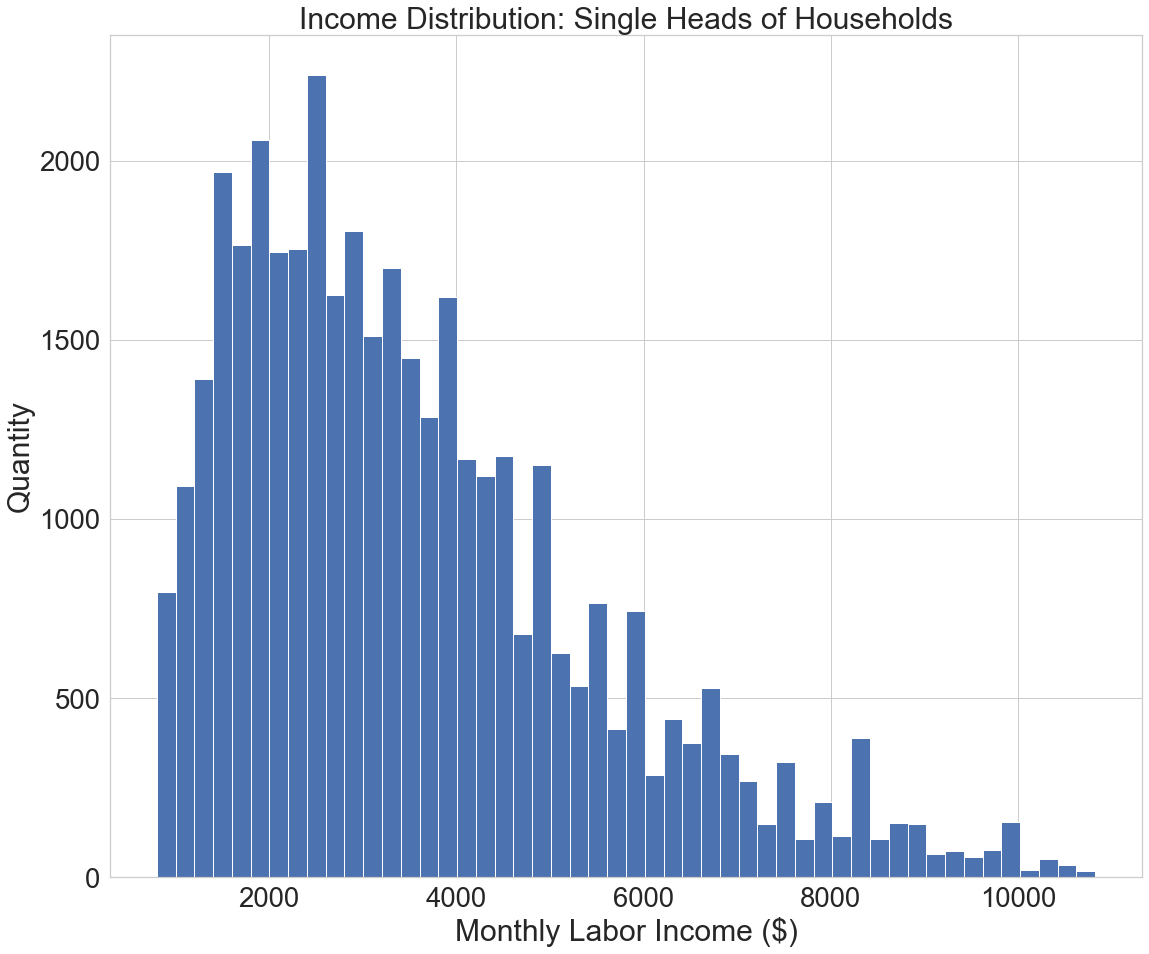

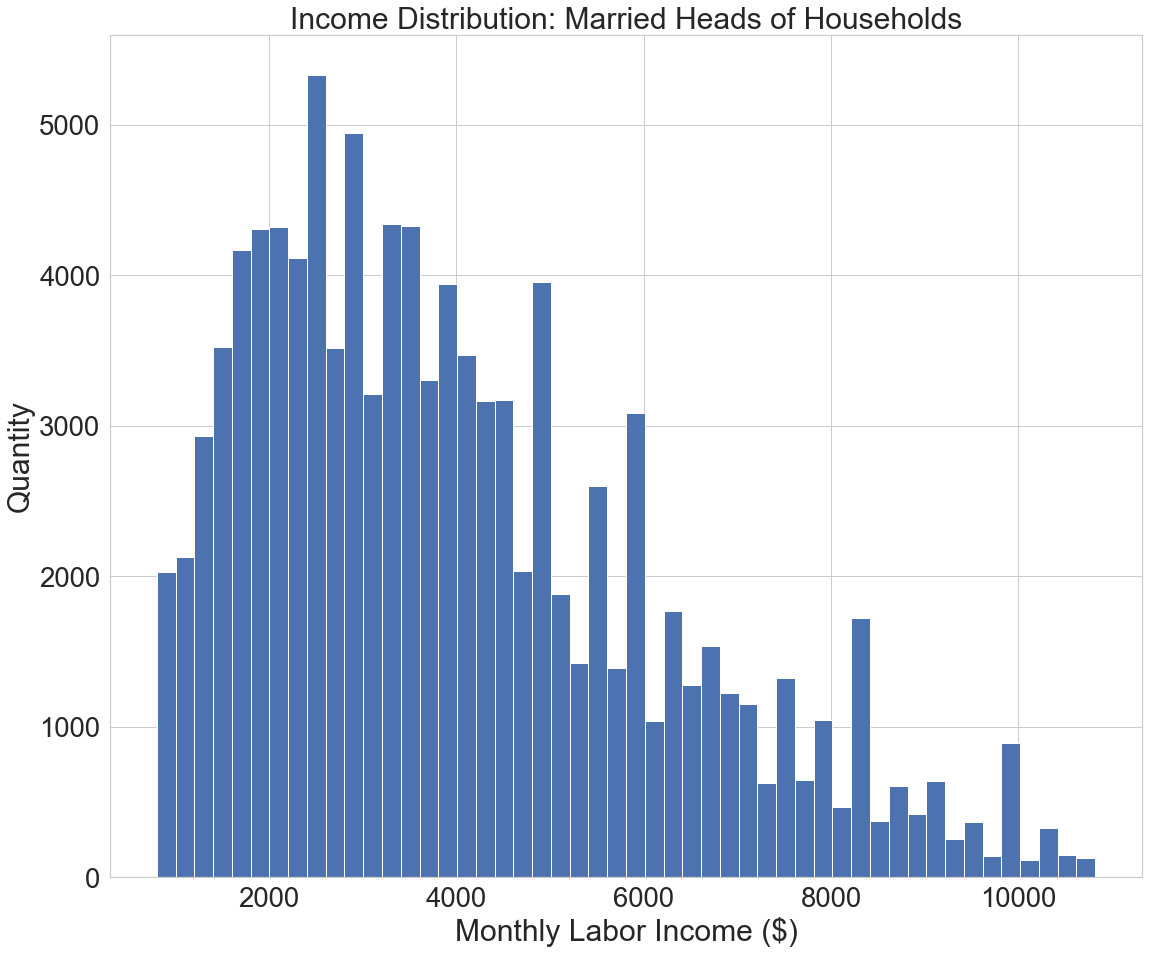

In [184]:
#### Income Distribution


# Histogram Plot for Single Heads of Households
income_single = final_data[(final_data.spouse == 0) & (final_data[income_var] > 0) & (final_data[income_var] < 14000)][income_var]

quantity, income_single, bars = plt.hist(income_single, bins = 50)
plt.title('Income Distribution: Single Heads of Households')
plt.xlabel('Monthly Labor Income ($)')
plt.ylabel('Quantity')
plt.show()


# Histogram Plot for Married Heads of Households
income_married = final_data[(final_data.spouse == 1) & (final_data[income_var] > 0) & (final_data[income_var] < 14000)][income_var]

quantity, income_married, bars = plt.hist(income_married, bins = 50)
plt.title('Income Distribution: Married Heads of Households')
plt.xlabel('Monthly Labor Income ($)')
plt.ylabel('Quantity')
plt.show()




## Stimulus Payments Distribution

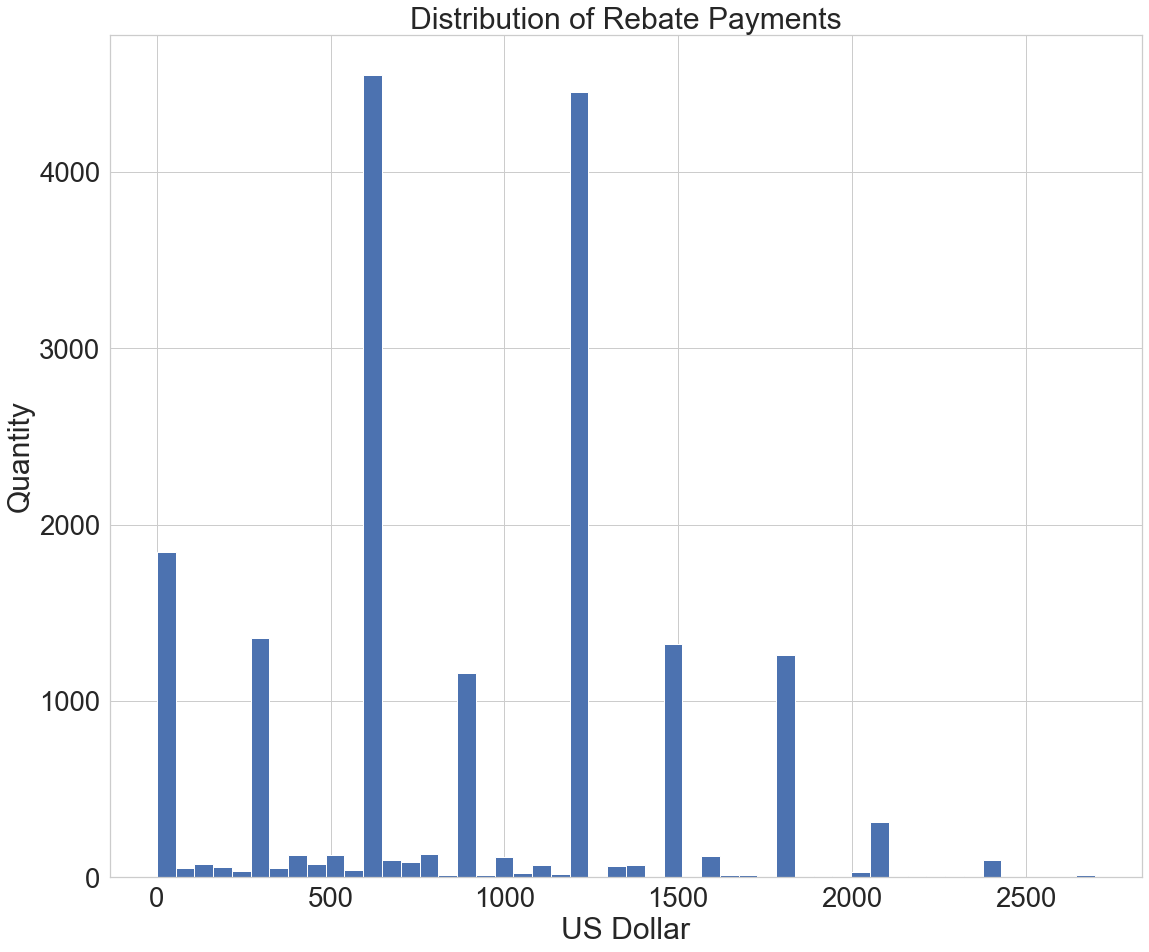

,Quantity,Percentage
reb_size,,
600.0,4524,25.21 %
1200.0,4443,24.76 %
0.0,1788,9.96 %
300.0,1337,7.45 %
1500.0,1321,7.36 %
1800.0,1257,7.01 %
900.0,1148,6.4 %
2100.0,313,1.74 %
800.0,125,0.7 %


In [185]:
#### Stimulus Payment Distribution


# Get the amounts of all rebate payments in the data and take every 8th element of this list to avoid double counting of rebate payments
values = final_data.reb_size[0::8]

quantity, rebate_size, bars = plt.hist(values, bins = 50)
plt.title('Distribution of Rebate Payments')
plt.xlabel('US Dollar')
plt.ylabel('Quantity')
plt.show()


# Statistics to the histogram plot
stats = pd.DataFrame(final_data[0::8].groupby(['reb_size']).size().sort_values(ascending = False))
stats.columns = ['Quantity']
stats['Percentage'] = round(stats.Quantity / sum(stats.Quantity) * 100,2).astype(str) + ' %'
stats.head(10)




## Stimulus Payments for Rich Households

In [186]:
#### Stimulus Payments for Rich Households

# Single households with more than 9,000 USD monthly income
rich_singles = final_data[(final_data.spouse == 0) & (final_data[income_var] >= 9000)]
rich_singles_rebate = rich_singles.reb_receipt.mean()*100
print(round(rich_singles_rebate,2),'percent of single households with monthly earnings of at least 9,000 USD received rebate payments in 2008.')

# Married households with more than 9,000 USD monthly income
rich_married = final_data[(final_data.spouse == 1) & (final_data[income_var] >= 9000)]
rich_married_rebate = rich_married.reb_receipt.mean()*100
print(round(rich_married_rebate,2),'percent of married households with monthly earnings of at least 9,000 USD received rebate payments in 2008.')


39.22 percent of single households with monthly earnings of at least 9,000 USD received rebate payments in 2008.
75.75 percent of married households with monthly earnings of at least 9,000 USD received rebate payments in 2008.


## Stimulus Payments Categorized by Monthly Labor Earnings

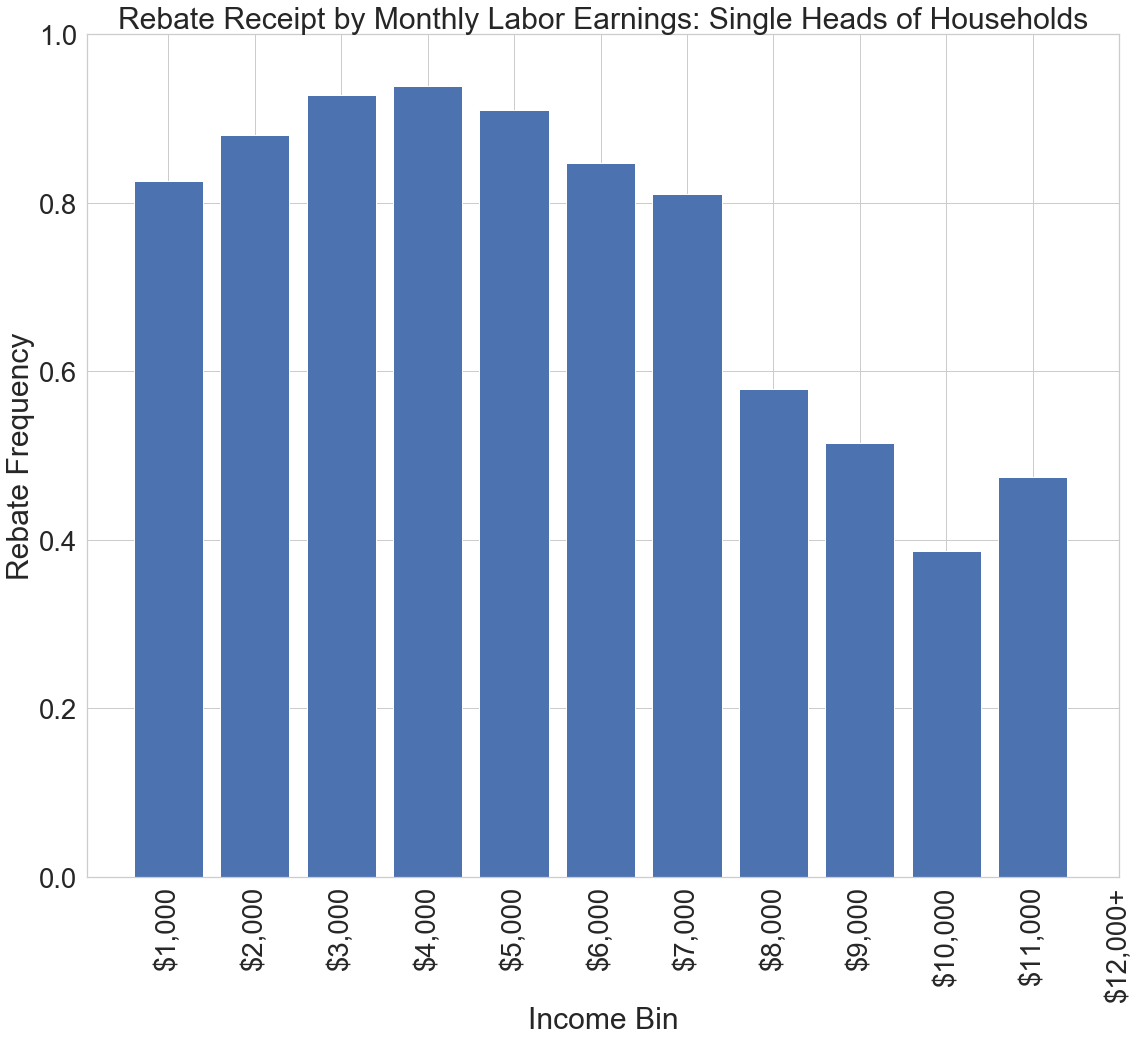

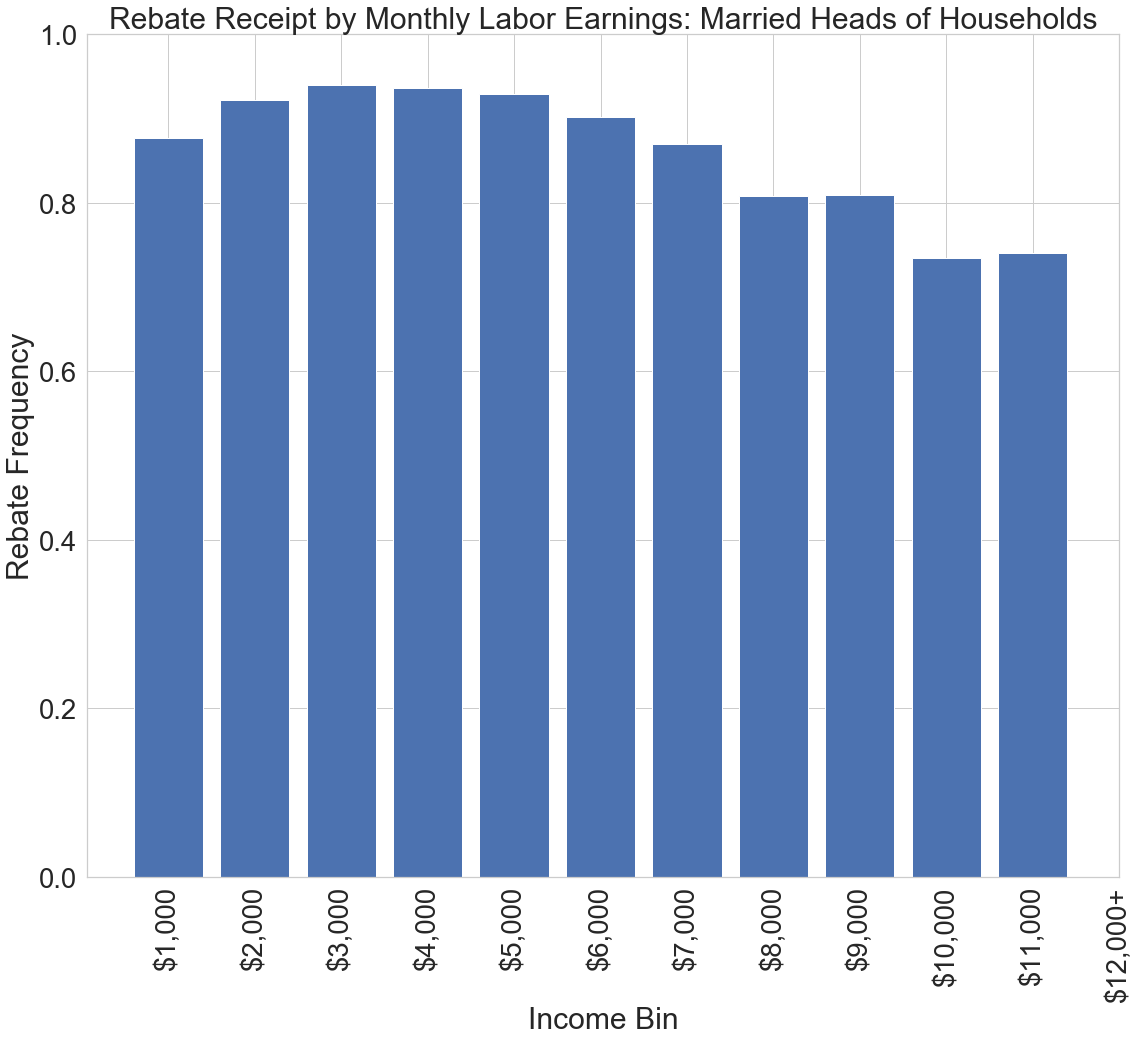

In [187]:
#### Stimulus Payments Categorized by Monthly Labor Earnings



## Single Heads of Households

bin1 = final_data[(final_data.spouse == 0) & (final_data[income_var] <= 1500)].reb_receipt.mean()
bin2 = final_data[(final_data.spouse == 0) & (final_data[income_var] > 1500) & (final_data[income_var] <= 2500)].reb_receipt.mean()
bin3 = final_data[(final_data.spouse == 0) & (final_data[income_var] > 2500) & (final_data[income_var] <= 3500)].reb_receipt.mean()
bin4 = final_data[(final_data.spouse == 0) & (final_data[income_var] > 3500) & (final_data[income_var] <= 4500)].reb_receipt.mean()
bin5 = final_data[(final_data.spouse == 0) & (final_data[income_var] > 4500) & (final_data[income_var] <= 5500)].reb_receipt.mean()
bin6 = final_data[(final_data.spouse == 0) & (final_data[income_var] > 5500) & (final_data[income_var] <= 6500)].reb_receipt.mean()
bin7 = final_data[(final_data.spouse == 0) & (final_data[income_var] > 6500) & (final_data[income_var] <= 7500)].reb_receipt.mean()
bin8 = final_data[(final_data.spouse == 0) & (final_data[income_var] > 7500) & (final_data[income_var] <= 8500)].reb_receipt.mean()
bin9 = final_data[(final_data.spouse == 0) & (final_data[income_var] > 8500) & (final_data[income_var] <= 9500)].reb_receipt.mean()
bin10 = final_data[(final_data.spouse == 0) & (final_data[income_var] > 9500) & (final_data[income_var] <= 10500)].reb_receipt.mean()
bin11 = final_data[(final_data.spouse == 0) & (final_data[income_var] > 10500) & (final_data[income_var] <= 11500)].reb_receipt.mean()
bin12 = final_data[(final_data.spouse == 0) & (final_data[income_var] > 11500)].reb_receipt.mean()


income_bin = ('$1,000', '$2,000', '$3,000', '$4,000', '$5,000', '$6,000', '$7,000', '$8,000', '$9,000', '$10,000', '$11,000', '$12,000+')
y_pos = np.arange(len(income_bin))
rebate_frequency = [bin1, bin2, bin3, bin4, bin5, bin6, bin7, bin8, bin9, bin10, bin11, bin12] # insert y-values here

plt.bar(y_pos, rebate_frequency, align='center', alpha=1)
plt.xticks(y_pos, income_bin, rotation = 90)
plt.ylim(0.0,1.0)
plt.xlabel('Income Bin')
plt.ylabel('Rebate Frequency')
plt.title('Rebate Receipt by Monthly Labor Earnings: Single Heads of Households')
plt.show()


## Married Heads of Households


bin1 = final_data[(final_data.spouse == 1) & (final_data[income_var] <= 1500)].reb_receipt.mean()
bin2 = final_data[(final_data.spouse == 1) & (final_data[income_var] > 1500) & (final_data[income_var] <= 2500)].reb_receipt.mean()
bin3 = final_data[(final_data.spouse == 1) & (final_data[income_var] > 2500) & (final_data[income_var] <= 3500)].reb_receipt.mean()
bin4 = final_data[(final_data.spouse == 1) & (final_data[income_var] > 3500) & (final_data[income_var] <= 4500)].reb_receipt.mean()
bin5 = final_data[(final_data.spouse == 1) & (final_data[income_var] > 4500) & (final_data[income_var] <= 5500)].reb_receipt.mean()
bin6 = final_data[(final_data.spouse == 1) & (final_data[income_var] > 5500) & (final_data[income_var] <= 6500)].reb_receipt.mean()
bin7 = final_data[(final_data.spouse == 1) & (final_data[income_var] > 6500) & (final_data[income_var] <= 7500)].reb_receipt.mean()
bin8 = final_data[(final_data.spouse == 1) & (final_data[income_var] > 7500) & (final_data[income_var] <= 8500)].reb_receipt.mean()
bin9 = final_data[(final_data.spouse == 1) & (final_data[income_var] > 8500) & (final_data[income_var] <= 9500)].reb_receipt.mean()
bin10 = final_data[(final_data.spouse == 1) & (final_data[income_var] > 9500) & (final_data[income_var] <= 10500)].reb_receipt.mean()
bin11 = final_data[(final_data.spouse == 1) & (final_data[income_var] > 10500) & (final_data[income_var] <= 11500)].reb_receipt.mean()
bin12 = final_data[(final_data.spouse == 1) & (final_data[income_var] > 11500)].reb_receipt.mean()


income_bin = ('$1,000', '$2,000', '$3,000', '$4,000', '$5,000', '$6,000', '$7,000', '$8,000', '$9,000', '$10,000', '$11,000', '$12,000+')
y_pos = np.arange(len(income_bin))
rebate_frequency = [bin1, bin2, bin3, bin4, bin5, bin6, bin7, bin8, bin9, bin10, bin11, bin12] # insert y-values here

plt.bar(y_pos, rebate_frequency, align='center', alpha=1)
plt.xticks(y_pos, income_bin, rotation = 90)
plt.ylim(0.0,1.0)
plt.xlabel('Income Bin')
plt.ylabel('Rebate Frequency')
plt.title('Rebate Receipt by Monthly Labor Earnings: Married Heads of Households')
plt.show()


## Stimulus Payments Categorized by Month

,Quantity,Percentage
Rebate Month,,
June,5325,29.68 %
May,5009,27.91 %
July,3584,19.97 %
No rebate,1788,9.96 %
April,1138,6.34 %
August,705,3.93 %
September,178,0.99 %
October,104,0.58 %
November,78,0.43 %


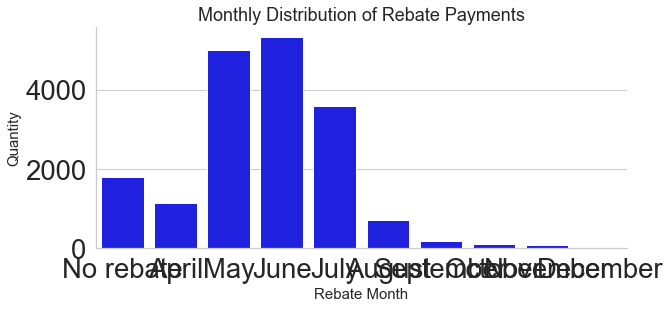

In [188]:
# Histogram
months = ['No rebate', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
sns.catplot(x='reb_month',  kind='count', color = 'blue', data=final_data[0::8], height=5, aspect=2, order = months)
plt.xlabel('Rebate Month', size=15)
plt.ylabel('Quantity', size=15)
plt.title('Monthly Distribution of Rebate Payments', size=18)
plt.tight_layout()


# Statistics to the histogram plot
stats = pd.DataFrame(final_data[0::8].groupby(['reb_month']).size().sort_values(ascending = False))
stats.columns = ['Quantity']
stats['Percentage'] = round(stats.Quantity / sum(stats.Quantity) * 100,2).astype(str) + ' %'
stats.index.names = ['Rebate Month']
stats

# Uplifting

**Idea:**

**First Step**

I build two random forests, one that is trained with the treatment group data, and one that is using the control group data only.

I split the treatment and control group into a training sample and a test sample in order to fit and test both algorithms. 

**Second Step**

I use both algorithms for predicting labor income values. For every household, I will get a prediction from the treatment random forest and one from the control random forest. Taking the difference results in the labor income change for each household in a given observation month. 

Important: For my predictions in Step 2, I do **NOT** use all observations in the original data set. In fact, I only predict values for months where a rebate payment happened and months after. 

Below, you will see sections 7.1 and 7.2. In 7.1, I will conduct the First Step, whereas in 7.2 I will select the observations whose predictions I am really interested in. 

## Select Data for Algorithmus Fit

In [6]:
## Exclude features that are not used for the analysis   
    
data = final_data.drop(['sum of hours worked', 'average hourly wage', 'individual_id', 'ssuid', 'type', 'totwork', 'ehrefper', 'epppnum', income_var_mean, 'totcens', 'whfnwgt', 
                        'reb4', 'amt4', 'reb5', 'amt5', 'reb6', 'amt6', 'reb7', 'amt7', 'reb8', 'amt8', 
                        'reb9', 'amt9', 'reb10', 'amt10', 'reb11', 'amt11', 'reb12', 'amt12', 'totearn', 
                        'tfearn', 'tftotinc', 'tptotinc', 'totinc', 'srefmon', 'reb_month', 'month'], axis = 1)



#### Uplifting

# Split the dataset into two sets for treatment and control group
treatment = data[data.rebate_payment == 1]
control = data[data.rebate_payment == 0]

# TFEARN as the target variable, which I call label
treatment_labels = treatment[income_var]
control_labels = control[income_var]

# Remove the labels from the features
treatment_features = treatment.drop(['labor_income_ratio', income_var], axis = 1)
control_features = control.drop(['rebate_uplifting', 'rebate_uplifting_spend', 'rebate_uplifting_save', 
                                               'rebate_uplifting_debt','labor_income_ratio', income_var], axis = 1)

# Saving feature names for later use
treatment_features_list = list(treatment_features.columns)
control_features_list = list(control_features.columns)

## Select Rebate Months and Lags for Predictions

In [7]:
## Select months after rebate payments only for the predictions
rebates_receiving_households = final_data[final_data.reb_receipt == 1]
result_months = rebates_receiving_households[(rebates_receiving_households.month_numerical >= rebates_receiving_households.reb_month_numerical) | (rebates_receiving_households.year == 2009)]



result_months_drop = result_months.drop(['sum of hours worked', 'average hourly wage', 'individual_id', 'ssuid', 'type', 'totwork', 'ehrefper', 'epppnum', income_var_mean, 'totcens', 'whfnwgt', 
                        'reb4', 'amt4', 'reb5', 'amt5', 'reb6', 'amt6', 'reb7', 'amt7', 'reb8', 'amt8', 
                        'reb9', 'amt9', 'reb10', 'amt10', 'reb11', 'amt11', 'reb12', 'amt12', 'totearn', 
                        'tfearn', 'tftotinc', 'tptotinc', 'totinc', 'srefmon', 'reb_month', 'month'], axis = 1)


features = result_months_drop.drop(['labor_income_ratio', income_var], axis = 1)
features_list = list(features.columns)


labels = result_months[income_var]

rebates = result_months.reb_size

# Split the data

In [8]:
#### Split the data

# Split the data into training and testing sets
treatment_train_features, treatment_test_features, treatment_train_labels, treatment_test_labels = train_test_split(treatment_features, treatment_labels, test_size = 0.2, random_state = 0)
control_train_features, control_test_features, control_train_labels, control_test_labels = train_test_split(control_features, control_labels, test_size = 0.2, random_state = 0)

# Random Forest

## Drop the dummy variables

In [9]:
## Select variables to be dropped

to_drop = ['reb_spend', 'reb_save', 'reb_debt', 'reb_size', 'reb_receipt', 
           'year_2008', 'year_2009', 'Dummy_January', 'Dummy_February', 
           'Dummy_March', 'Dummy_May', 'Dummy_June', 'Dummy_July', 'Dummy_August', 
           'Dummy_September', 'Dummy_October', 'Dummy_November', 'Dummy_December', 
           'First Reference month', 'Second Reference month', 'Third Reference month', 
           'Fourth Reference month', 'Wave_1', 'Wave_2'] # drop all the dummy variables that I don't need for the RF



rf_treatment_train_features = treatment_train_features.drop(to_drop, axis = 1)
rf_treatment_test_features = treatment_test_features.drop(to_drop, axis = 1)

rf_control_train_features = control_train_features.drop(to_drop, axis = 1)
rf_control_test_features = control_test_features.drop(to_drop, axis = 1)

rf_treatment_features = features.drop(to_drop, axis = 1)
rf_control_features = rf_treatment_features.drop(['rebate_uplifting', 'rebate_uplifting_spend', 
                                                    'rebate_uplifting_save', 'rebate_uplifting_debt'], axis = 1)


# Saving the random forest feature names for later use
rf_treatment_features_list = rf_features_list = list(rf_treatment_features.columns)
rf_control_features_list = list(rf_control_features.columns)

## Train the Random Forest Algorithm and make Predictions

In [194]:
#### Setting up the RF #########################################

rf_treatment = RandomForestRegressor(n_estimators = n_est, random_state = r_s, max_depth = m_d, 
                                            max_features = feat, oob_score = oob_score, bootstrap = bootstrap)
rf_control = RandomForestRegressor(n_estimators = n_est, random_state = r_s, max_depth = m_d, 
                                            max_features = feat, oob_score = oob_score, bootstrap = bootstrap)


#### Train the RF #########################################

# Train the model on training data
rf_treatment.fit(rf_treatment_train_features, treatment_train_labels);
rf_control.fit(rf_control_train_features, control_train_labels);

# Report scores for both random forest models
rf_treatment_training_score = rf_treatment.score(rf_treatment_train_features, treatment_train_labels);
rf_control_training_score = rf_control.score(rf_control_train_features, control_train_labels);

rf_treatment_oob_score = rf_treatment.oob_score_
rf_control_oob_score = rf_control.oob_score_

rf_treatment_test_score = rf_treatment.score(rf_treatment_test_features, treatment_test_labels);
rf_control_test_score = rf_control.score(rf_control_test_features, control_test_labels);



#### Predict with the RF ####################################


#### Make Predictions on the Training Set

# Use the forest's predict method on the training data
rf_treatment_train_predictions = rf_treatment.predict(rf_treatment_train_features)
rf_control_train_predictions = rf_control.predict(rf_control_train_features)

# Calculate the absolute errors
rf_treatment_train_errors = abs(rf_treatment_train_predictions - treatment_train_labels)
rf_control_train_errors = abs(rf_control_train_predictions - control_train_labels)


#### Make Predictions on the Test Set

# Use the forest's predict method on the test data
rf_treatment_test_predictions = rf_treatment.predict(rf_treatment_test_features)
rf_control_test_predictions = rf_control.predict(rf_control_test_features)

# Calculate the absolute errors
rf_treatment_test_errors = abs(rf_treatment_test_predictions - treatment_test_labels)
rf_control_test_errors = abs(rf_control_test_predictions - control_test_labels)


#### Make predictions for whole data

# Predict labor income
rf_treatment_predictions = rf_treatment.predict(rf_treatment_features)
rf_control_predictions = rf_control.predict(rf_control_features)

# Calculate the absolute errors
rf_treatment_errors = abs(rf_treatment_predictions - labels)
rf_control_errors = abs(rf_control_predictions - labels)


####
rf_treatment_score = rf_treatment.score(rf_treatment_features, labels);
rf_control_score = rf_control.score(rf_control_features, labels);




#### Compute the differences between the treatment and control group
rf_diff = rf_treatment_predictions - rf_control_predictions
rf_mean_diff = np.mean(rf_diff)
rf_median_diff = np.median(rf_diff)

#################################################################################################################

#### Create a new row with the percentual labor income change for every observation
rf_perc_diff = np.divide(rf_diff, labels)# * 100 # to transform it into percentage points
rf_perc_diff[np.isinf(rf_perc_diff)] = 0
rf_mean_perc_diff = np.mean(rf_perc_diff)
rf_median_perc_diff = np.median(rf_perc_diff)



#################################################################################################################

#### Create a new row with the marginal labor income change for every rebate dollars
rf_marg_diff = np.divide(rf_diff, rebates)# * 100 # to transform it into percentage points
rf_marg_diff[np.isinf(rf_marg_diff)] = 0
rf_mean_marg_diff = np.mean(rf_marg_diff)
rf_median_marg_diff = np.median(rf_marg_diff)



#################################################################################################################


#### Attach the results to the final_data Dataframe - this is needed for further analysis! 

result_months['rf_treatment_predictions'] = rf_treatment_predictions
result_months['rf_control_predictions'] = rf_control_predictions
result_months['rf_labor_income_diff'] = rf_diff
result_months['rf_perc_labor_income_diff'] = rf_perc_diff
result_months['rf_marg_labor_income_diff'] = rf_marg_diff

result_months['Monthly Working Hour Change'] = result_months['rf_labor_income_diff'] / result_months['average hourly wage']
result_months['Monthly Working Hour Percentage Change'] = result_months['Monthly Working Hour Change'] / result_months['sum of hours worked']
result_months['Monthly Working Hour Change for each Rebate Dollar Received'] = result_months['Monthly Working Hour Change'] / result_months['reb_size']

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:100: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:101: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexi

## Results

In [195]:
## Results for rebate months only

dataframe_data = result_months[final_data.rebate_payment == 1]

rf_results_rebate_month = pd.DataFrame([[round(np.mean(dataframe_data.rf_labor_income_diff),3), round(np.std(dataframe_data.rf_labor_income_diff), 3), 
                                         round(min(dataframe_data.rf_labor_income_diff),3), round(np.percentile(dataframe_data.rf_labor_income_diff,25),3), 
                                         round(np.median(dataframe_data.rf_labor_income_diff),3), round(np.percentile(dataframe_data.rf_labor_income_diff,75),3), 
                                         round(max(dataframe_data.rf_labor_income_diff), 3)],
                                        [round(np.mean(dataframe_data.rf_perc_labor_income_diff),3), round(np.std(dataframe_data.rf_perc_labor_income_diff), 3), 
                                         round(min(dataframe_data.rf_perc_labor_income_diff),3), round(np.percentile(dataframe_data.rf_perc_labor_income_diff,25),3), 
                                         round(np.median(dataframe_data.rf_perc_labor_income_diff),3), round(np.percentile(dataframe_data.rf_perc_labor_income_diff,75),3), 
                                         round(max(dataframe_data.rf_perc_labor_income_diff), 3)],
                                        [round(np.mean(dataframe_data.rf_marg_labor_income_diff),3), round(np.std(dataframe_data.rf_marg_labor_income_diff), 3), 
                                         round(min(dataframe_data.rf_marg_labor_income_diff),3), round(np.percentile(dataframe_data.rf_marg_labor_income_diff,25),3), 
                                         round(np.median(dataframe_data.rf_marg_labor_income_diff),3), round(np.percentile(dataframe_data.rf_marg_labor_income_diff,75),3), 
                                         round(max(dataframe_data.rf_marg_labor_income_diff), 3)]],
                                    columns = list(['Mean Difference', 'Standard Deviation', 
                                                    'Min', '25th Percentile', 
                                                    'Median Difference', '75th Percentile', 
                                                    'Max']),  
                                    index = ['Labor Income Difference', 'Difference relative to Actual Labor Income', 
                                        'Difference relative to Rebate Amount'])

rf_results_rebate_month.columns.names = ['Rebate Months Only']
rf_results_rebate_month



C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:929: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


All Months,Mean Difference,Standard Deviation,Min,25th Percentile,Median Difference,75th Percentile,Max
Labor Income Difference,60.892,128.201,-601.919,-23.200,61.915,144.048,1191.755
Difference relative to Actual Labor Income,0.032,0.066,-0.567,-0.005,0.017,0.052,1.003
Difference relative to Rebate Amount,0.148,3.387,-160.572,-0.022,0.063,0.185,271.013
Rebate Months Only,Mean Difference,Standard Deviation,Min,25th Percentile,Median Difference,75th Percentile,Max
Labor Income Difference,-64.870,166.388,-601.919,-177.042,-47.669,48.538,1191.755
Difference relative to Actual Labor Income,-0.018,0.064,-0.567,-0.047,-0.013,0.014,0.439
Difference relative to Rebate Amount,-0.120,3.993,-160.572,-0.197,-0.054,0.045,269.136
Lags [1],Mean Difference,Standard Deviation,Min,25th Percentile,Median Difference,75th Percentile,Max
Labor Income Difference,22.851,109.537,-488.065,-63.593,37.076,90.897,889.144
Difference relative to Actual Labor Income,0.018,0.054,-0.251,-0.014,0.009,0.033,0.660


**CALCULATE MONTHLY WORKING HOUR CHANGES IN REBATE MONTHS**

In [211]:
## Select months for analysis

lag = [0]
selected_lags = lag_function(lag)

individual_monthly_working_hours_change = pd.DataFrame([[round(selected_lags['Monthly Working Hour Change'].mean(),3), 
                                              round(selected_lags['Monthly Working Hour Percentage Change'].mean(),3),
                                              round(selected_lags['Monthly Working Hour Change for each Rebate Dollar Received'].mean(),6)*1000],
                                             [round(selected_lags['Monthly Working Hour Change'].median(),3), 
                                              round(selected_lags['Monthly Working Hour Percentage Change'].median(),3),
                                              round(selected_lags['Monthly Working Hour Change for each Rebate Dollar Received'].median(),6)*1000]],
                        columns = list(['Hours Change', 'Hours Change (in %)', 
                                        'Hours Change per $1,000 rebate']), 
                        index = ['mean', 'median'])

individual_monthly_working_hours_change.columns.names = ['Individual-Level']


## For the household level computation, I aggregate the individual responses for each household in the sample
## Due to computational issues, I leave out the calculation of the percentage hour change on the household-level
## (I cannot just sum the percentual hour changes. And I lose the information on household size and individual hours worked
## when aggregating to the household-level.)

household_level = selected_lags.groupby(['ssuid']).sum()
household_monthly_working_hours_change = pd.DataFrame([[round(household_level['Monthly Working Hour Change'].mean(),3),
                                              round(household_level['Monthly Working Hour Change for each Rebate Dollar Received'].mean(),6)*1000],
                                             [round(household_level['Monthly Working Hour Change'].median(),3),
                                              round(household_level['Monthly Working Hour Change for each Rebate Dollar Received'].median(),6)*1000]],
                        columns = list(['Hours Change', 
                                        'Hours Change per $1,000 rebate']), 
                        index = ['mean', 'median'])

household_monthly_working_hours_change.columns.names = ['Household-Level']

display_below_each_other(individual_monthly_working_hours_change, household_monthly_working_hours_change)

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:929: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Individual-Level 
 Hours Change 
 Hours Change (in %) 
 Hours Change per $1,000 rebate 
 
 
 
 
 mean 
 -3.998 
 -0.018 
 -9.055 
 
 
 median 
 -2.260 
 -0.013 
 -2.577 
 
 
 
 
 
 Household-Level 
 Hours Change 
 Hours Change per $1,000 rebate 
 
 
 
 
 mean 
 -5.057 
 -11.454 
 
 
 median 
 -3.106 
 -3.788

## Accuracy

**First, I report the estimated R^2 scores**

In [17]:
# Arrange the score statistics in a table like format
rf_score = pd.DataFrame([[round(rf_treatment_training_score,4), round(rf_treatment_oob_score,4), round(rf_treatment_test_score,4), round(rf_treatment_score,4)],
                         [round(rf_control_training_score,4), round(rf_control_oob_score,4), round(rf_control_test_score,4), round(rf_control_score,4)]], 
                     columns = list(['R^2 Training Score', 'Out of Bag Score', 'R^2 Test Score', 'R^2 Entire Dataset Score']))

rf_score.rename(index = {0: 'Treatment', 1: 'Control'})


,R^2 Training Score,Out of Bag Score,R^2 Test Score,R^2 Entire Dataset Score
Treatment,0.2393,0.2165,0.2266,0.2109
Control,0.2432,0.2418,0.2429,0.2292


**Following the approach by Gulyas and Pytka, I construct 25 response bins and compare RF estimates with OLS estimates for each bin**

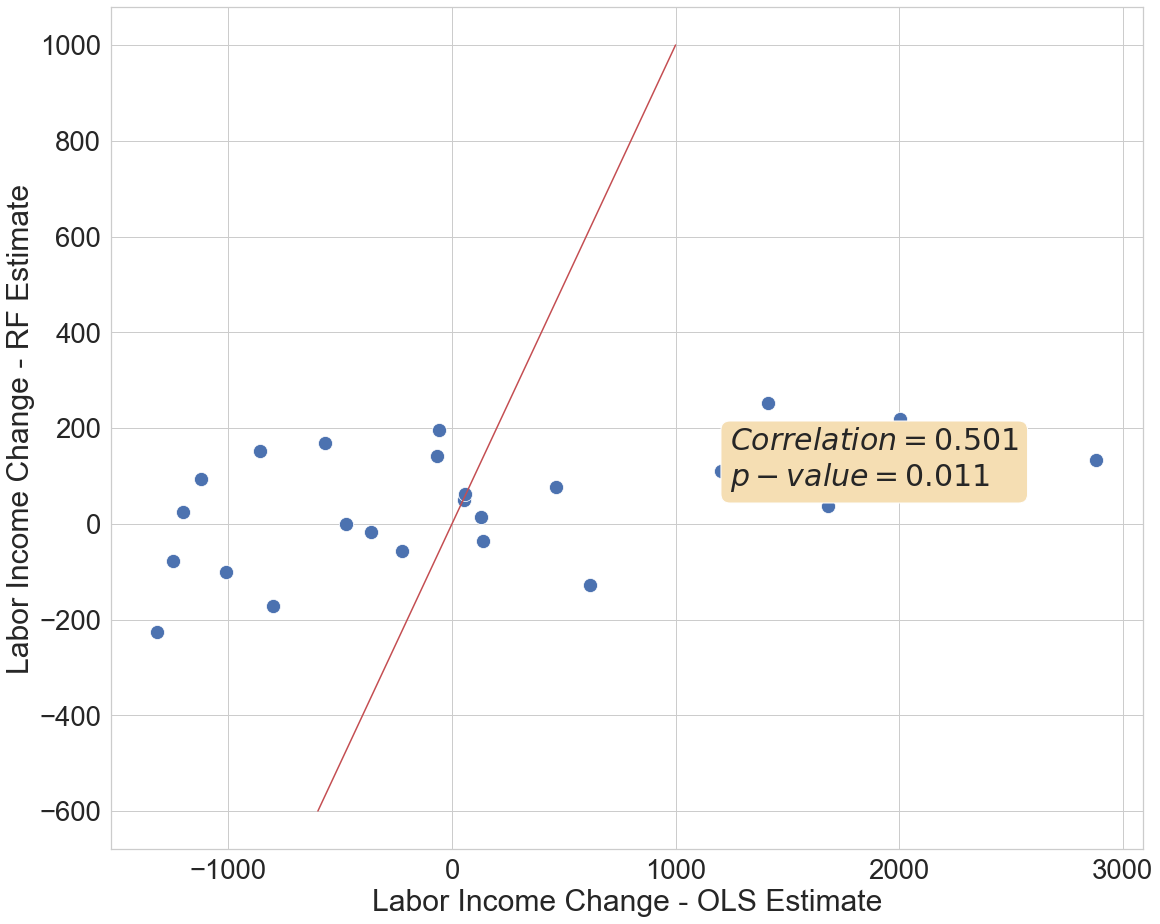

In [19]:
#### 1. Bin all individuals by their estimated labor income change into 25 bins and plot OLS estimates vs. RF estimates for each bin
data_accuracy = result_months.copy().drop('Is In Selected Lags', axis = 1)


data_accuracy = data_accuracy.sort_values(by = ['rf_labor_income_diff'])

rf_bins_estimates = []
ols_bins_estimates = []

# Create 25 bins
number_bins = 25
cut_points = np.arange(1,len(data_accuracy),len(data_accuracy)/number_bins)

for i, val in enumerate(cut_points):
    
    if i == 0:      
        
        df = data_accuracy.iloc[ 0:int(cut_points[1]) , : ]
    
    else: 
        df = data_accuracy.iloc[ int((val)-(val/(i+1))):int(val), : ]
    
    # RF estimates
    rf_bins_estimates.append(np.mean(df.rf_labor_income_diff))
        
    #OLS estimates
    ols_features = df[['rebate_payment', 'tage', 'famsize', 'spouse', 'flex', 'moonlit', 'selfemp', 
                                  'year_2008', 'year_2009', 'Dummy_January', 'Dummy_February', 'Dummy_March', 
                                  'Dummy_May', 'Dummy_June', 'Dummy_July', 'Dummy_August', 'Dummy_September', 
                                  'Dummy_October', 'Dummy_November', 'Dummy_December', 'First Reference month', 
                                  'Second Reference month', 'Third Reference month', 'Fourth Reference month', 
                                  'reb_month_numerical', 'Wave_1', 'Wave_2', 'rebate_uplifting_spend', 'rebate_uplifting_save', 
                                  'rebate_uplifting_debt']]
    ols_label = df['tfearn']
    ols_model = LinearRegression()
    ols_results = ols_model.fit(ols_features, ols_label)
    ols_bins_estimates.append(ols_results.coef_[0])


sns.set(rc = {'figure.figsize': (18.5,15.5)})
sns.set(font_scale=2.5)
sns.set_style('whitegrid')


pearson_coef, p = pearsonr(ols_bins_estimates, rf_bins_estimates)


fig, ax = plt.subplots()

text = '\n'.join((
    r'$Correlation=%.3f$' % (pearson_coef, ),
    r'$p-value=%.3f$' % (p, )))

sns.scatterplot(ols_bins_estimates,rf_bins_estimates, s = 200, ax = ax)

props = dict(boxstyle='round', facecolor='wheat', alpha=1)

ax.text(0.6, 0.5, text, transform=ax.transAxes, fontsize=30,
        verticalalignment='top', bbox=props)


ax.set(xlabel = 'Labor Income Change - OLS Estimate', ylabel = 'Labor Income Change - RF Estimate')

x = np.linspace(-600, 1000, 10)
sns.lineplot(x,x, ax=ax, color = 'r')
data_accuracy = result_months.copy().drop('Is In Selected Lags', axis = 1)


data_accuracy = data_accuracy.sort_values(by = ['rf_labor_income_diff'])

rf_bins_estimates = []
ols_bins_estimates = []

# Create 25 bins
number_bins = 25
cut_points = np.arange(1,len(data_accuracy),len(data_accuracy)/number_bins)

for i, val in enumerate(cut_points):
    
    if i == 0:      
        
        df = data_accuracy.iloc[ 0:int(cut_points[1]) , : ]
    
    else: 
        df = data_accuracy.iloc[ int((val)-(val/(i+1))):int(val), : ]
    
    # RF estimates
    rf_bins_estimates.append(np.mean(df.rf_labor_income_diff))
        
    #OLS estimates
    ols_features = df[['rebate_payment', 'tage', 'famsize', 'spouse', 'flex', 'moonlit', 'selfemp', 
                                  'year_2008', 'year_2009', 'Dummy_January', 'Dummy_February', 'Dummy_March', 
                                  'Dummy_May', 'Dummy_June', 'Dummy_July', 'Dummy_August', 'Dummy_September', 
                                  'Dummy_October', 'Dummy_November', 'Dummy_December', 'First Reference month', 
                                  'Second Reference month', 'Third Reference month', 'Fourth Reference month', 
                                  'reb_month_numerical', 'Wave_1', 'Wave_2', 'rebate_uplifting_spend', 'rebate_uplifting_save', 
                                  'rebate_uplifting_debt']]
    ols_label = df['tfearn']
    ols_model = LinearRegression()
    ols_results = ols_model.fit(ols_features, ols_label)
    ols_bins_estimates.append(ols_results.coef_[0])


sns.set(rc = {'figure.figsize': (18.5,15.5)})
sns.set(font_scale=2.5)
sns.set_style('whitegrid')


pearson_coef, p = pearsonr(ols_bins_estimates, rf_bins_estimates)


fig, ax = plt.subplots()

text = '\n'.join((
    r'$Correlation=%.3f$' % (pearson_coef, ),
    r'$p-value=%.3f$' % (p, )))

sns.scatterplot(ols_bins_estimates,rf_bins_estimates, s = 200, ax = ax)

props = dict(boxstyle='round', facecolor='wheat', alpha=1)

ax.text(0.6, 0.5, text, transform=ax.transAxes, fontsize=30,
        verticalalignment='top', bbox=props)


ax.set(xlabel = 'Labor Income Change - OLS Estimate', ylabel = 'Labor Income Change - RF Estimate')

x = np.linspace(-600, 1000, 10)
sns.lineplot(x,x, ax=ax, color = 'r')

**Calculate the Rank Correlation**

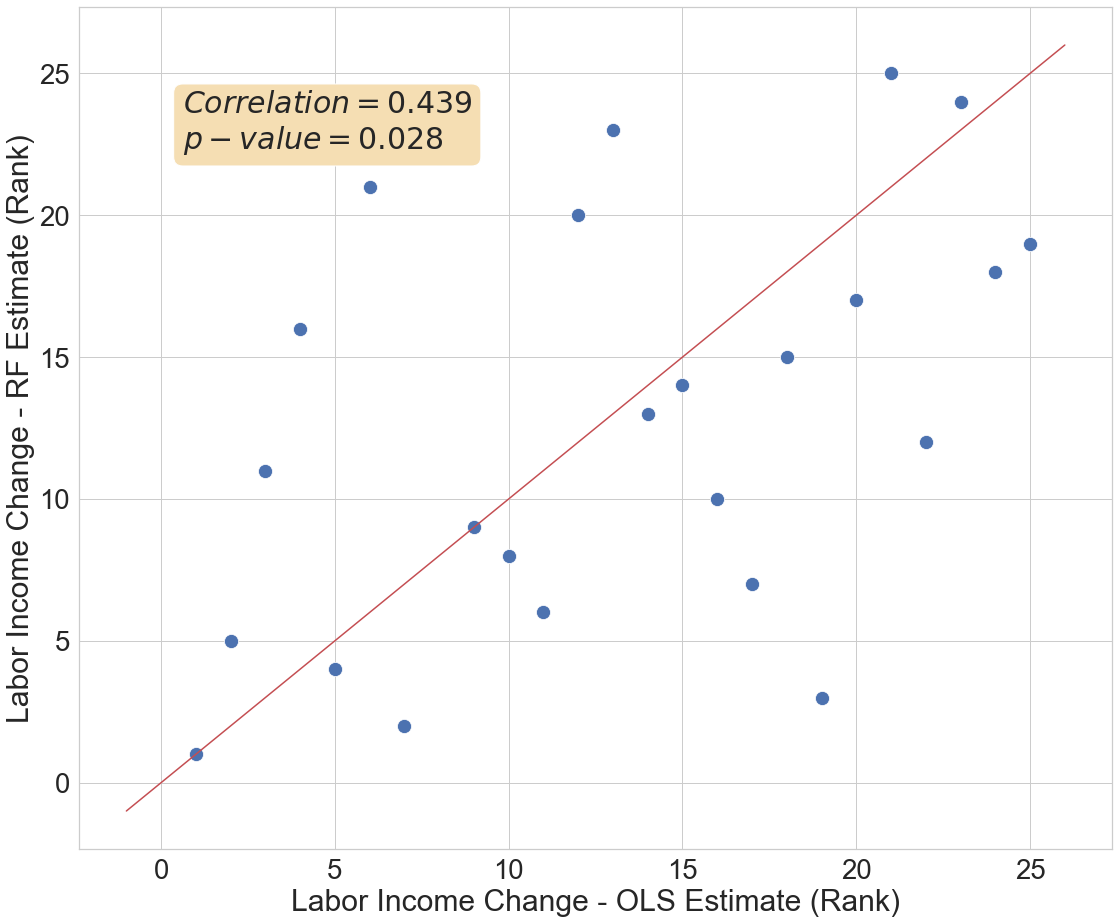

In [20]:
#### 2. Compute the ranks for both estimations and compare RF ranks with OLS ranks

dtf_sorted = pd.DataFrame({'OLS Bins Estimate': np.sort(ols_bins_estimates), 
                    'OLS Rank': np.arange(1,number_bins+1,1)})

df_rank_preliminary = pd.DataFrame({'RF Bins Estimate': rf_bins_estimates, 
                        'OLS Bins Estimate': ols_bins_estimates, 
                        'RF Rank': np.arange(1,number_bins+1,1)})

df_rank = df_rank_preliminary.merge(dtf_sorted, on='OLS Bins Estimate')

rf_ranks = df_rank['RF Rank']
ols_ranks = df_rank['OLS Rank']

sns.set(rc = {'figure.figsize': (18.5,15.5)})
sns.set(font_scale=2.5)
sns.set_style('whitegrid')

spearman_coef, p = spearmanr(ols_bins_estimates, rf_bins_estimates)
fig, ax = plt.subplots()

text = '\n'.join((
    r'$Correlation=%.3f$' % (spearman_coef, ),
    r'$p-value=%.3f$' % (p, )))




sns.scatterplot(ols_ranks,rf_ranks, s = 200, ax = ax)

props = dict(boxstyle='round', facecolor='wheat', alpha=1)

ax.text(0.1, 0.9, text, transform=ax.transAxes, fontsize=30,
        verticalalignment='top', bbox=props)


ax.set(xlabel = 'Labor Income Change - OLS Estimate (Rank)', ylabel = 'Labor Income Change - RF Estimate (Rank)')

x = np.linspace(-1, number_bins+1, 5)
sns.lineplot(x,x, ax=ax, color = 'r')

# Analysis

## Feature Importance

**COCKPIT FOR VARIABLE SETTING:**

In [143]:
# Select the input variables right here

feature_names_model_1 = rf_control_features.columns
feature_names_model_2 = rf_treatment_features.columns
model_1 = rf_control
model_2 = rf_treatment
name_model_1 = 'Control Group'
name_model_2 = 'Treatment Group'
random_state = 0

### Feature correlation

Print a standard Pearson's correlation matrix.

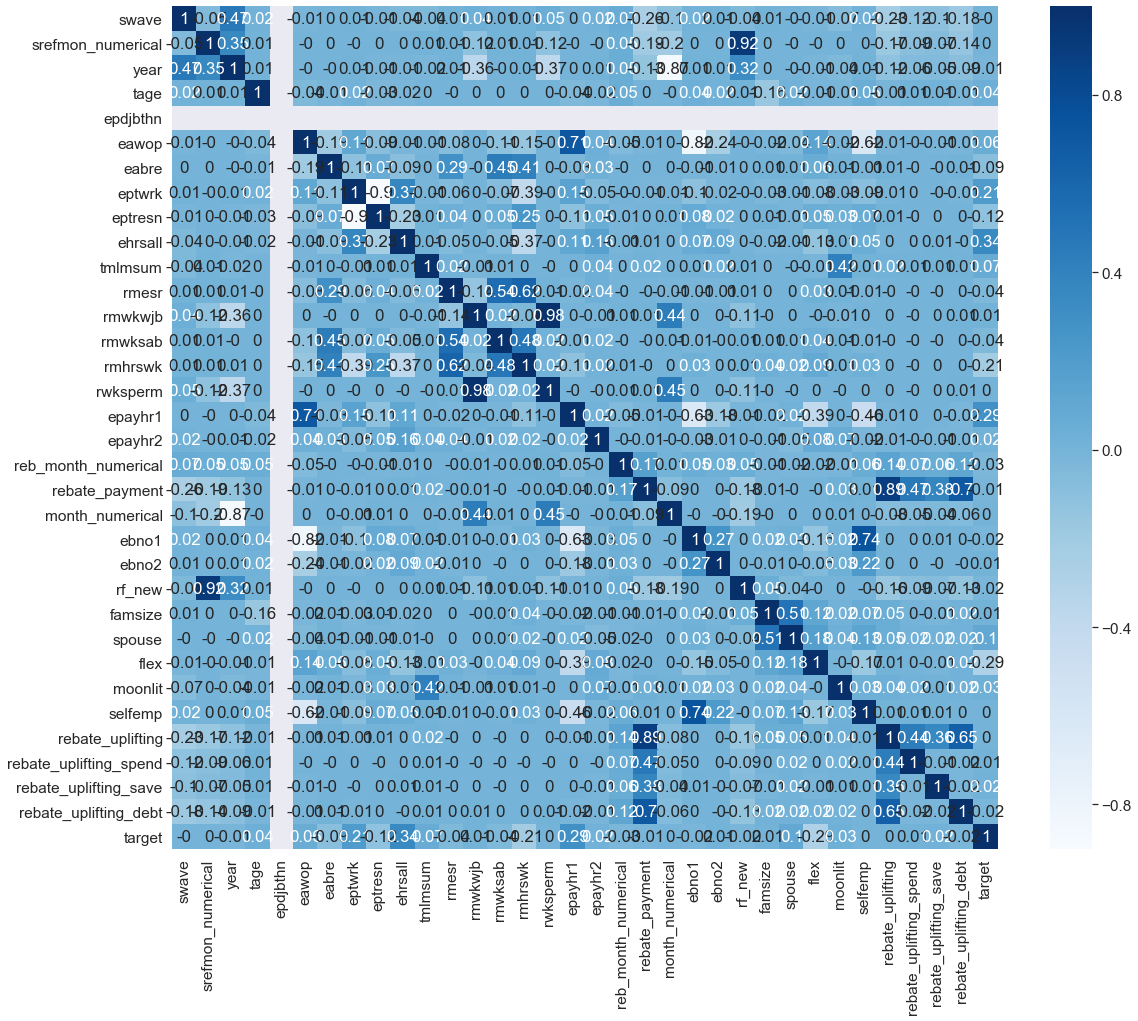

In [144]:
## Pearson Correlation Matrix

features = rf_treatment_features
target = labels

sns.set(font_scale=14)
fig, ax = plt.subplots(figsize=(18.5,15.5)) 
pear_corr = sns.heatmap(features.assign(target = target).corr().round(2),cmap = 'Blues', annot = True)
pear_corr

Print a Spearman's correlation matrix which first transforms variables into ranks and then runs the Pearson's correlation on these ranks.

C:\Users\User\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2530: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\User\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2531: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
C:\Users\User\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\Users\User\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\Users\User\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


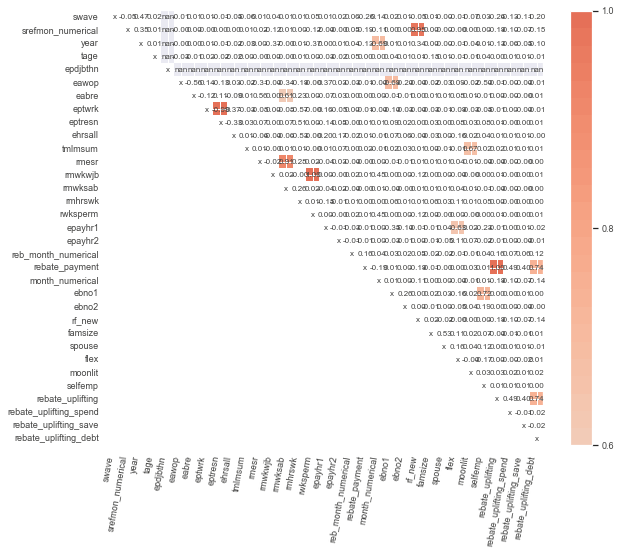

In [145]:
## Spearman Correlation Matrix


#sns.set(font_scale=25)
sns.set(font_scale=14)
fig, ax = plt.subplots(figsize=(10,8)) 
spear_corr = plot_corr_heatmap(features)


Apart from small exceptions, the features used for predictions are not correlated. This will be important for the computation of the permutation feature importances, since they tend to overestimate the importance of correlated predictors.

### Impurity based default computation

In [149]:
# Plot the feature importances as a table
default_imp = imp_df(feature_names_model_1, feature_names_model_2, model_1, model_2, name_model_1, name_model_2)
default_imp

,Feature,Control Group feature importance,Treatment Group feature importance
0,epayhr1,0.306843,0.269698
1,ehrsall,0.209257,0.213372
2,flex,0.175716,0.124102
3,rmhrswk,0.124043,0.127389
4,eptresn,0.058267,0.051301
5,eptwrk,0.040188,0.037656
6,reb_month_numerical,0.019127,0.006171
7,tage,0.016981,0.017213
8,spouse,0.016361,0.013913
9,eawop,0.007750,0.007945


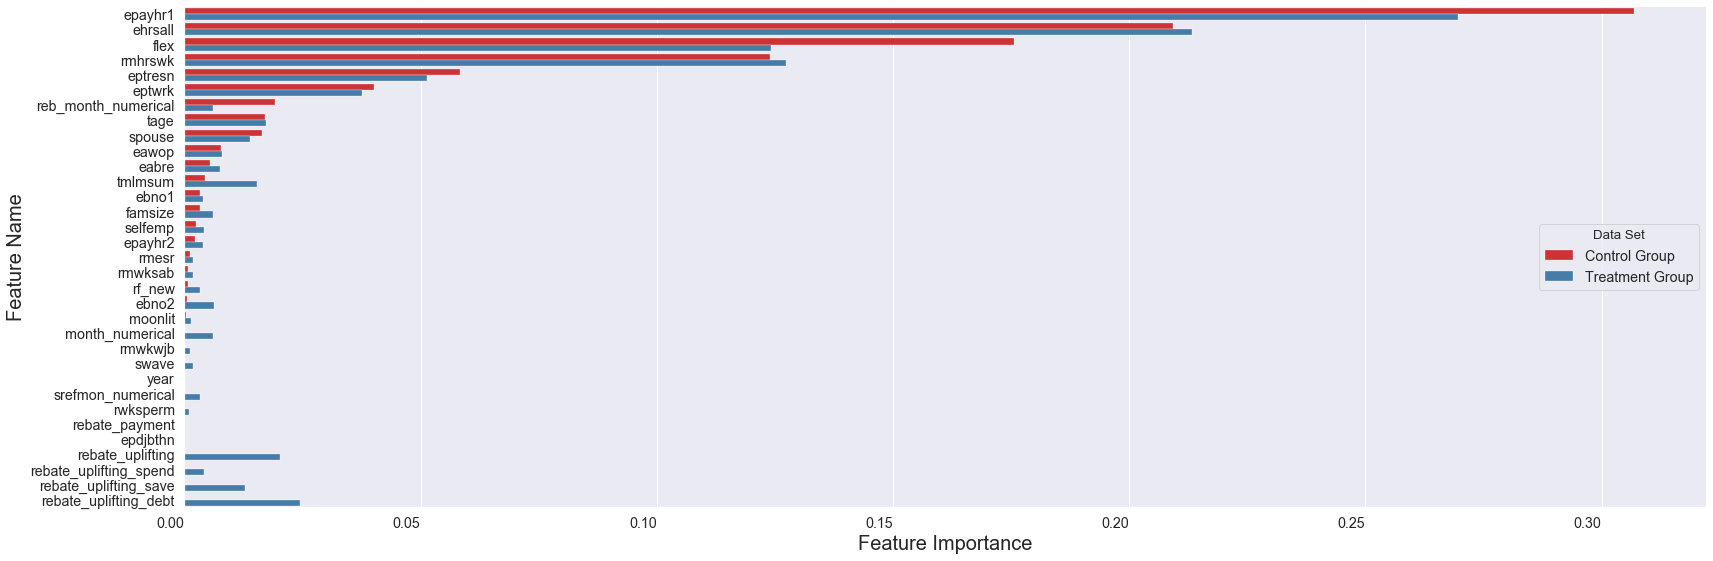

In [151]:
# Plot the feature importances as a graph
df = default_imp.copy()
title = 'Default Scikit Feature Importance'

default_plot = feat_imp_plot(df, name_model_1, name_model_2, title)
default_plot

### Permutation based computation

What is the **difference** between the default computation of feature importances and the permutation feature importance?

The permutation feature importances are computed on a held out dataset, whereas the default scikit feature importances are measured on the complete training set. The biggest shortcoming of the default computation is the fact that it is biased towards high cardinality features. This means that features that have a high number of different unique values are given a higher significance. Another disadvantage of the impurity based default computation of the feature importance is that it does not take into account the ability of features to actually make good predictions. In contrast, random re-shuffling of values from one feature in the dataset and, hence, creating permuted datasets which are used for making predictions and measuring the accuracy can mitigate the limitations. 

As already mentioned above, one shortcoming of the permutation importance is the overestimation of correlated predictors' importances (see Strobl et al., 2008).

#### rfpimp

In [152]:
## Permutation based Feature Importances with rfpimp

perm_imp_rfpimp = perm_imp_rfpimp_df(feature_names_model_1, feature_names_model_2, model_1, model_2, name_model_1, name_model_2)
perm_imp_rfpimp

C:\Users\User\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


,Feature,Control Group feature importance,Treatment Group feature importance
0,epayhr1,0.099195,0.105061
1,ehrsall,0.057135,0.058594
2,flex,0.029293,0.029334
3,rmhrswk,0.024602,0.034297
4,spouse,0.009901,0.003957
5,eptresn,0.009756,0.009526
6,eptwrk,0.009745,0.009737
7,tage,0.004228,0.005217
8,tmlmsum,0.002586,0.001650
9,eawop,0.001380,0.001245


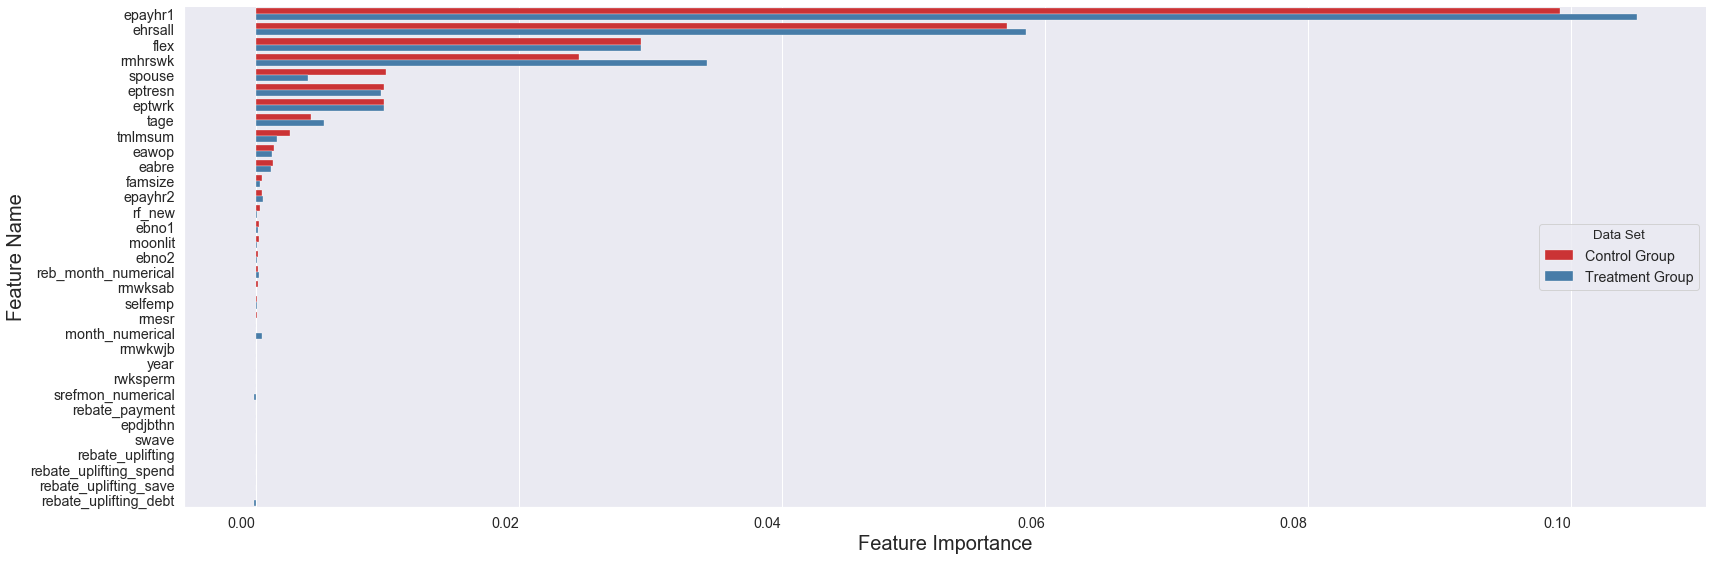

In [153]:
## Plot

df = perm_imp_rfpimp.copy()
title = 'Permutation Feature Importance using rfpimp'

perm_imp_rfpimp_plot = feat_imp_plot(df, name_model_1, name_model_2, title)
perm_imp_rfpimp_plot

#### eli5

In [154]:
## Permutation based Feature Importances with rfpimp

perm_imp_eli5 = perm_imp_eli5_df(feature_names_model_1, feature_names_model_2, model_1, model_2, name_model_1, name_model_2)
perm_imp_eli5

,Feature,Control Group feature importance,Treatment Group feature importance
0,epayhr1,0.099434,0.099435
1,ehrsall,0.058342,0.061030
2,flex,0.031118,0.029675
3,rmhrswk,0.024975,0.030822
4,eptresn,0.010460,0.010063
5,eptwrk,0.009107,0.009821
6,spouse,0.008079,0.004273
7,tage,0.006187,0.003909
8,tmlmsum,0.001863,0.001799
9,eawop,0.001216,0.000559


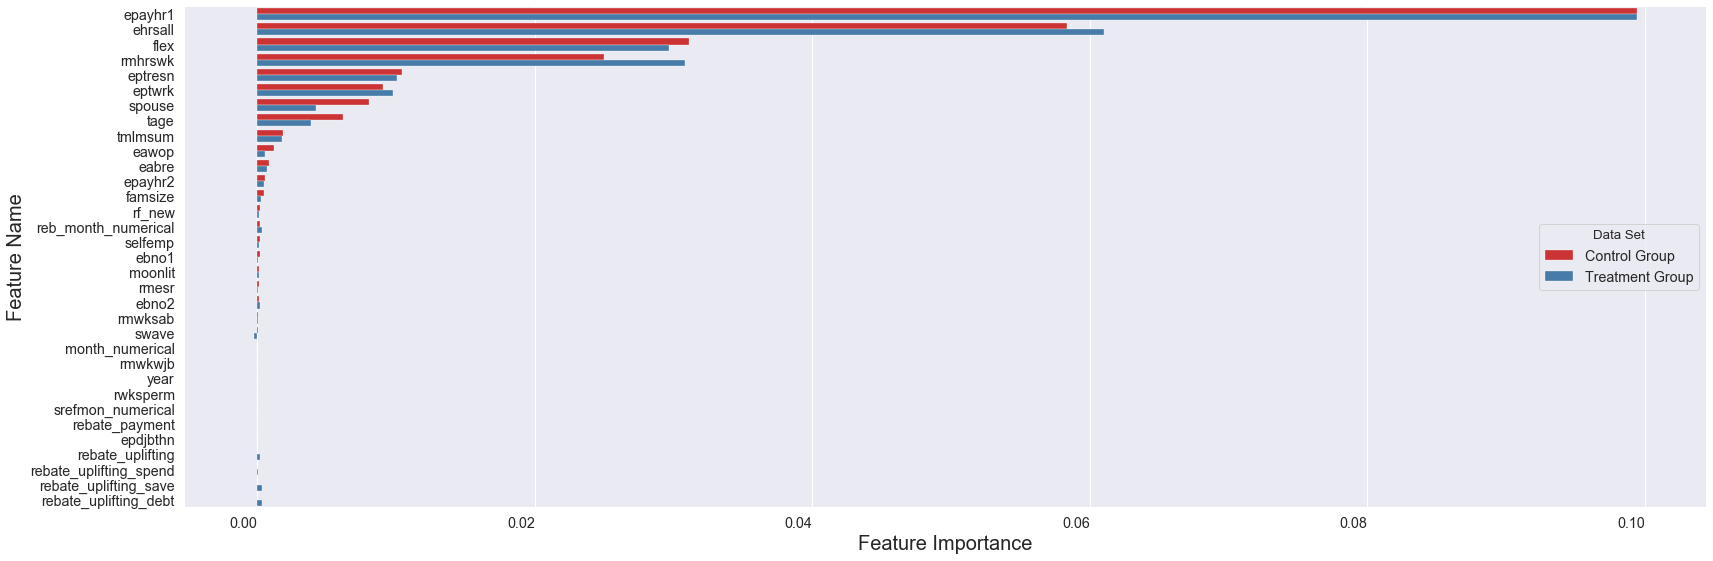

In [155]:
## Plot

df = perm_imp_eli5.copy()
title = 'Permutation Feature Importance using eli5'

perm_imp_eli5_plot = feat_imp_plot(df, name_model_1, name_model_2, title)
perm_imp_eli5_plot

## Partial Dependence Plots

**Variable Overview**

**Cockpit for parameter setting**

In [97]:
## Change values only for the variable chosen_feature

kind = 'Absolute' # Absolute, Percentual or Marginal
measure = 'Median' # Mean or Median
lag = [0] # Partial Dependence Plots as defined should only be used for lag 0! This is completely fine, since I focus my 
          # analysis on rebate months only


# Features to select from
#['swave', 'srefmon_numerical','year', 'tage', 'epdjbthn', 'eawop', 'eabre', 'eptwrk', 'eptresn', 'ehrsall', 'tmlmsum',
# 'rmesr','rmwkwjb', 'rmwksab', 'rmhrswk', 'rwksperm', 'epayhr1', 'epayhr2', 'reb_month_numerical', 'rebate_payment',
#'month_numerical', 'ebno1', 'ebno2', 'rf_new', 'famsize', 'spouse', 'flex', 'moonlit', 'selfemp', 'rebate_uplifting',
#'rebate_uplifting_spend', 'rebate_uplifting_save', 'rebate_uplifting_debt']

chosen_feature = 'eabre' 

### Single Plot

In [98]:
## DO NOT CHANGE ANYTHING IN THIS CELL !!!

## Features used for predicting
feature_names = rf_treatment_features_list #rf_features_list_tfearn # Do not change this row ! 
feature_pred = [rf_treatment_features_list.index(x) for x in feature_names] # Do not change this row ! It assures that all the features are used for the prediction.

## Selected feature for the partial dependence dataframe
pd_feature = rf_treatment_features_list.index(chosen_feature) # Do not change this row !

## Select the forecast models for the treatment and control predictions
model_1 = rf_control
model_2 = rf_treatment

## Select the lags
selected_lags = lag_function(lag)

##### Select the dataset for treatment and control predictions
X_1 = np.array(selected_lags[rf_control_features_list])
X_2 = np.array(selected_lags[rf_treatment_features_list])

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


**SHOW THE DATAFRAME:**

In [99]:
## Table with Results

result_table = pdp_df(model_1, model_2, X_1, X_2, feature_pred, pd_feature, kind)
result_table        

,Mean Absolute Difference,Median Absolute Difference,5th Percentile Absolute Difference,25th Percentile Absolute Difference,75th Percentile Absolute Difference,95th Percentile Absolute Difference,Standard Deviation Absolute Difference
eabre,,,,,,,
-1.0,-63.863328,-46.633991,-356.466360,-176.548184,50.296833,190.041136,166.977857
1.0,-86.665553,-65.109587,-377.875757,-195.337229,25.460200,159.281879,164.533558
2.0,-95.706033,-74.342425,-383.937506,-201.672023,15.005836,147.901294,162.744029
3.0,-98.689521,-77.185602,-386.548185,-205.513013,12.612999,145.676043,163.067591
4.0,-98.982078,-76.688536,-386.573991,-206.221100,11.782932,143.382297,162.903892
5.0,-100.564014,-78.675679,-387.329904,-207.200988,9.347376,141.736334,162.551353
6.0,-103.382721,-80.821917,-389.588597,-208.948455,4.930739,137.632754,161.890712
7.0,-104.917080,-82.136492,-390.912639,-210.746051,3.421442,136.091762,161.828919
8.0,-104.579488,-81.943136,-391.256511,-211.912283,4.411010,138.210047,162.631740


**SHOW THE PLOT:**

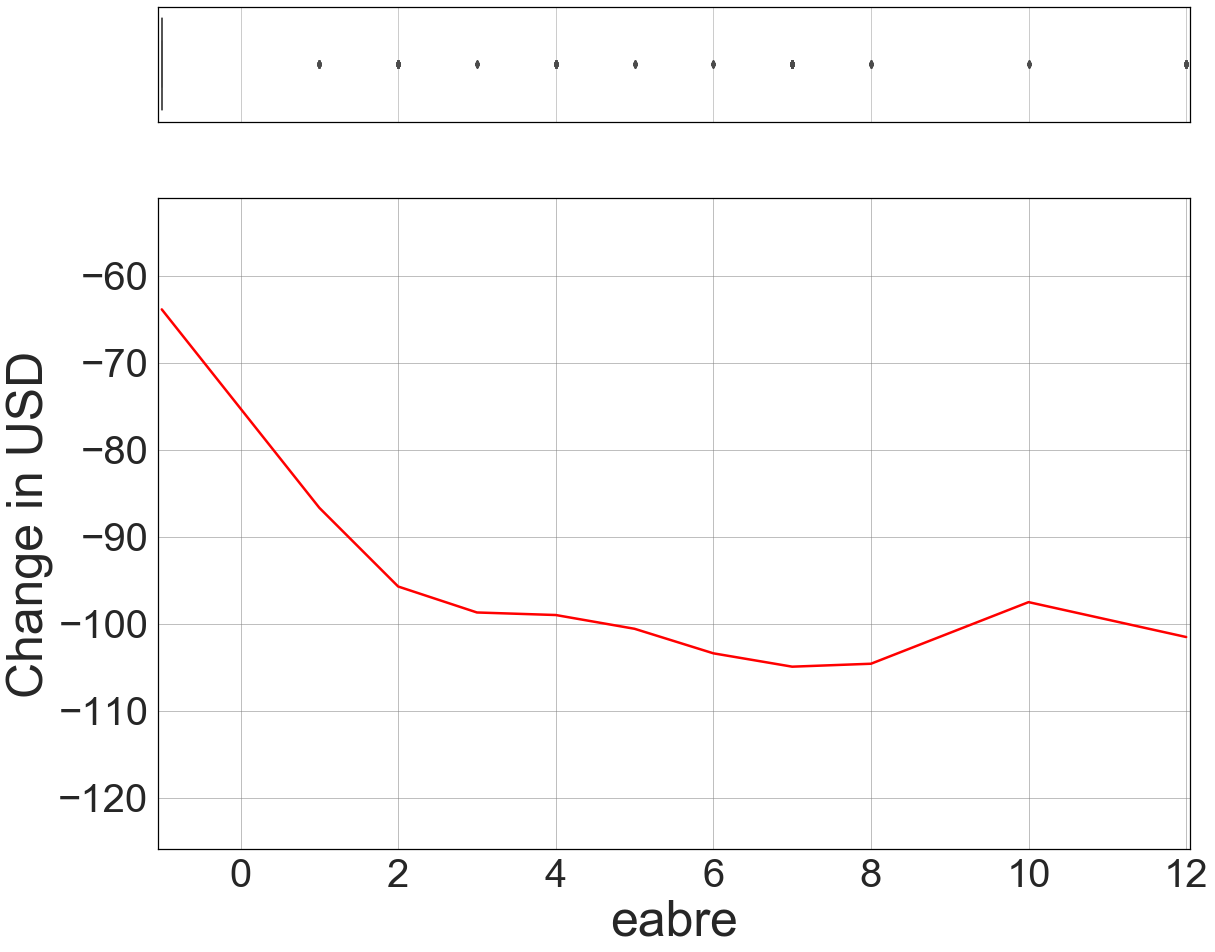

In [101]:
## Plot

df = result_table
measure = 'Mean'

pdp_plot(df, measure, kind)

### Multiple Plot

**SELECT THE FEATURES FOR THE PDP PLOTS:**

In [27]:
## Change values for kind, measure, the lags and choose the feature for the partial dependency computation

kind = 'Absolute' # Absolute, Percentual or Marginal
measure = 'Median' # Mean or Median
lag = [0] # Partial Dependence Plots as defined should only be used for lag 0! This is completely fine, since I focus my 
          # analysis on rebate months only


# Features to select from

#['swave', 'srefmon_numerical','year', 'tage', 'epdjbthn', 'eawop', 'eabre', 'eptwrk', 'eptresn', 'ehrsall', 'tmlmsum',
# 'rmesr','rmwkwjb', 'rmwksab', 'rmhrswk', 'rwksperm', 'epayhr1', 'epayhr2', 'reb_month_numerical', 'rebate_payment',
#'month_numerical', 'ebno1', 'ebno2', 'rf_new', 'famsize', 'spouse', 'flex', 'moonlit', 'selfemp', 'rebate_uplifting',
#'rebate_uplifting_spend', 'rebate_uplifting_save', 'rebate_uplifting_debt']

chosen_feature = ['epayhr1', 'ehrsall', 'rmesr', 'eptresn', 'eabre', 'rmwkwjb', 'rmwksab', 'rmhrswk']

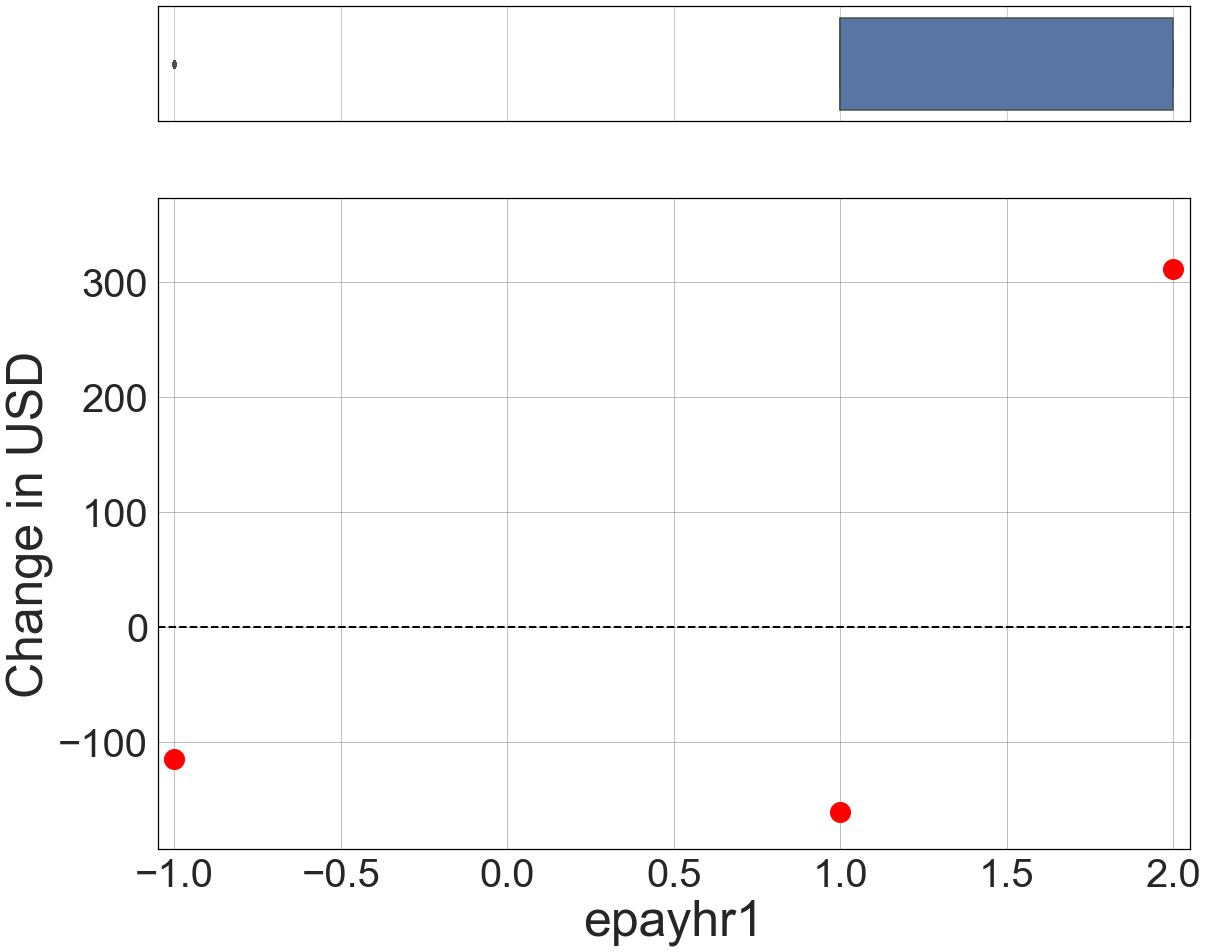

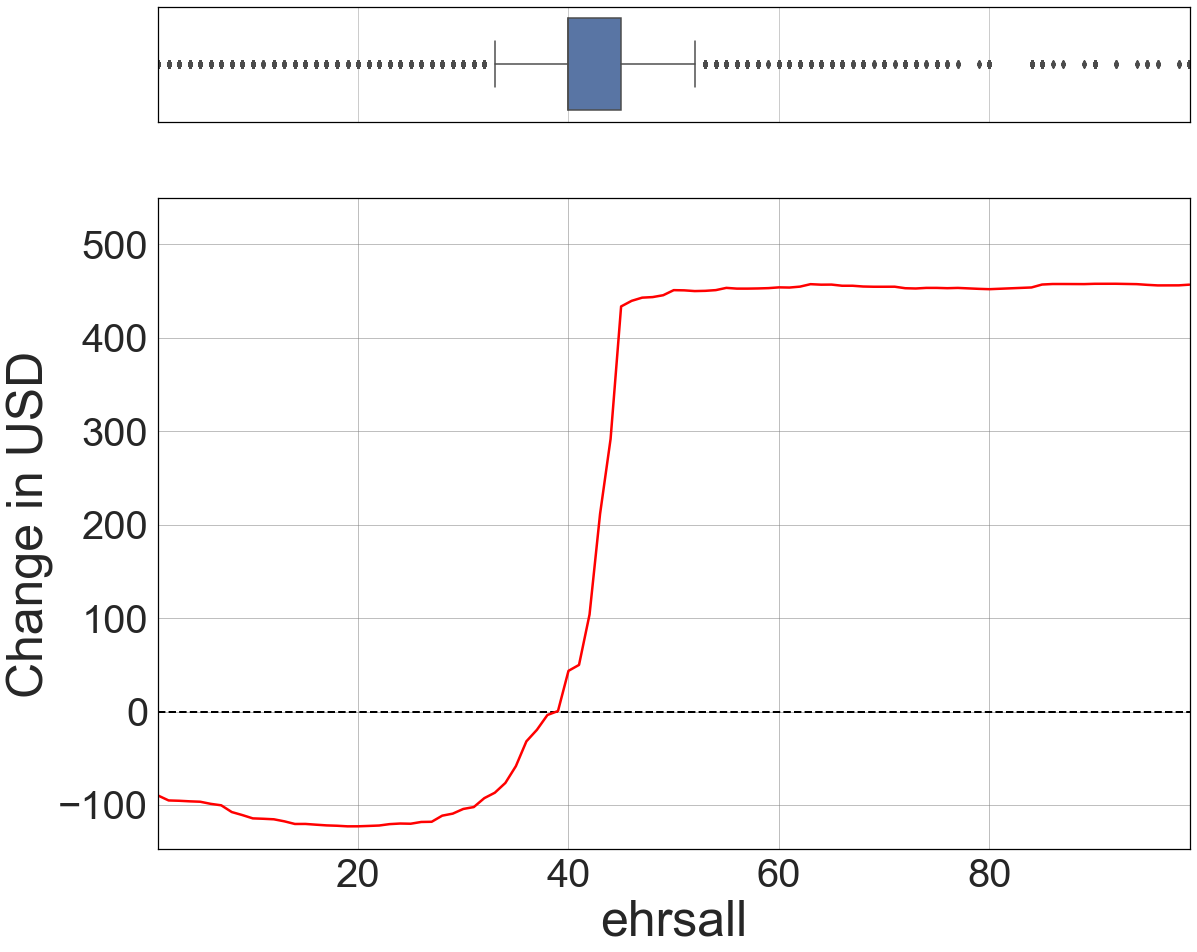

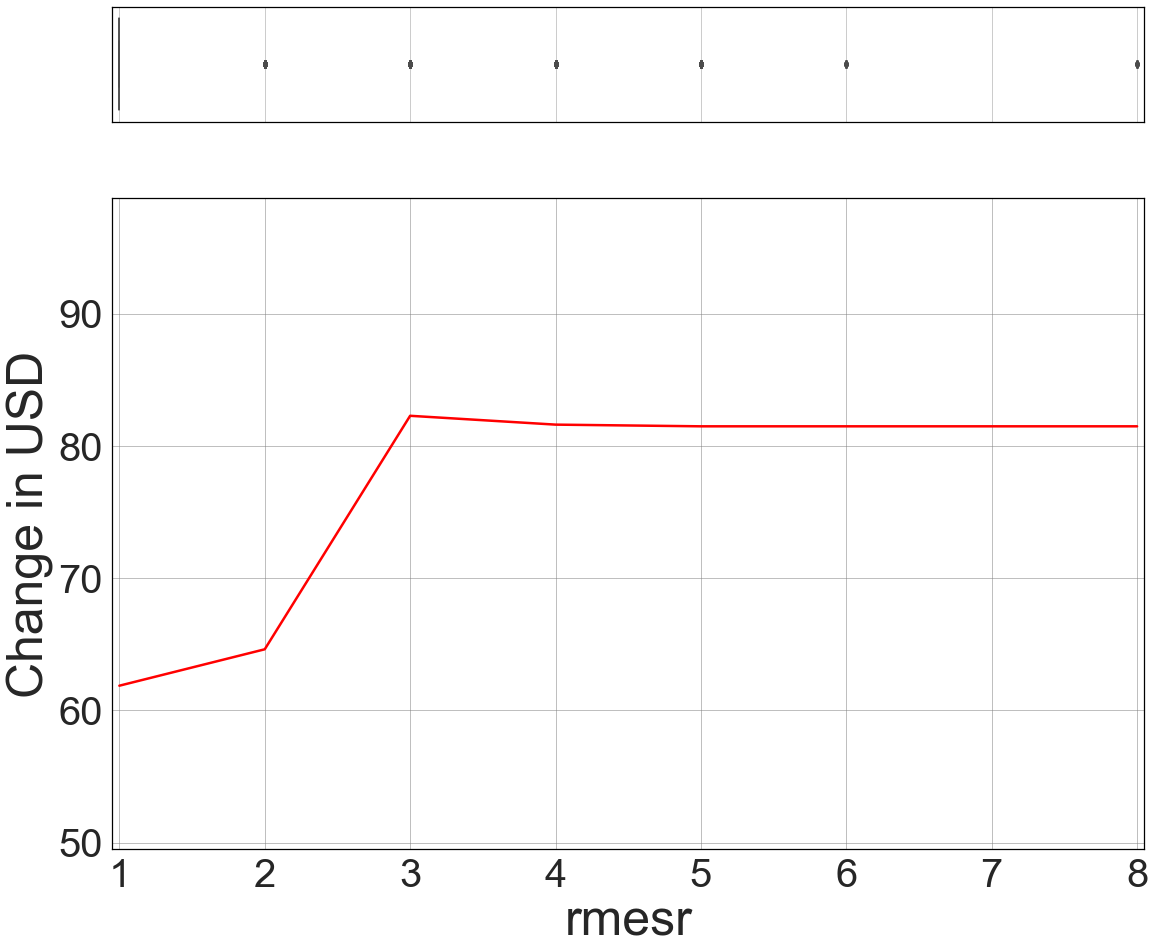

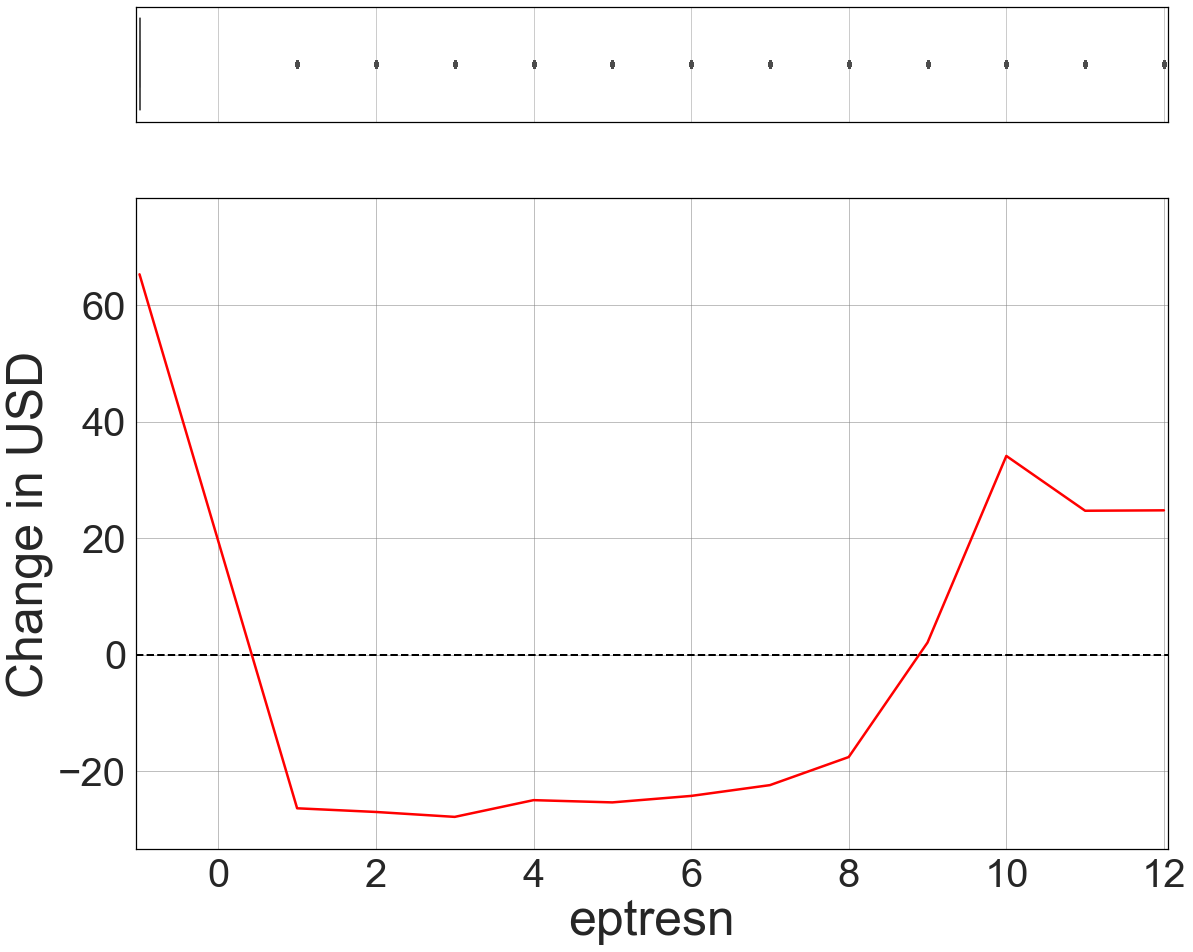

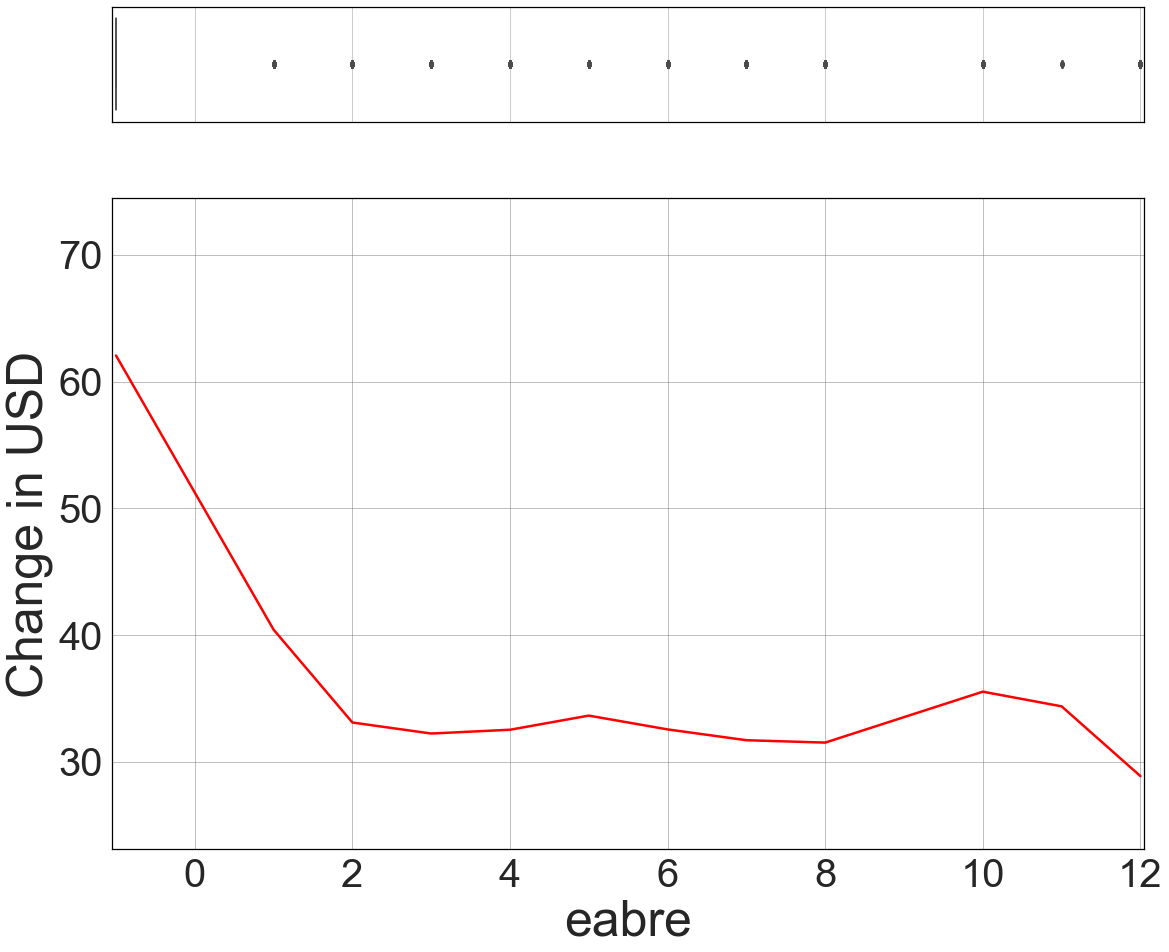

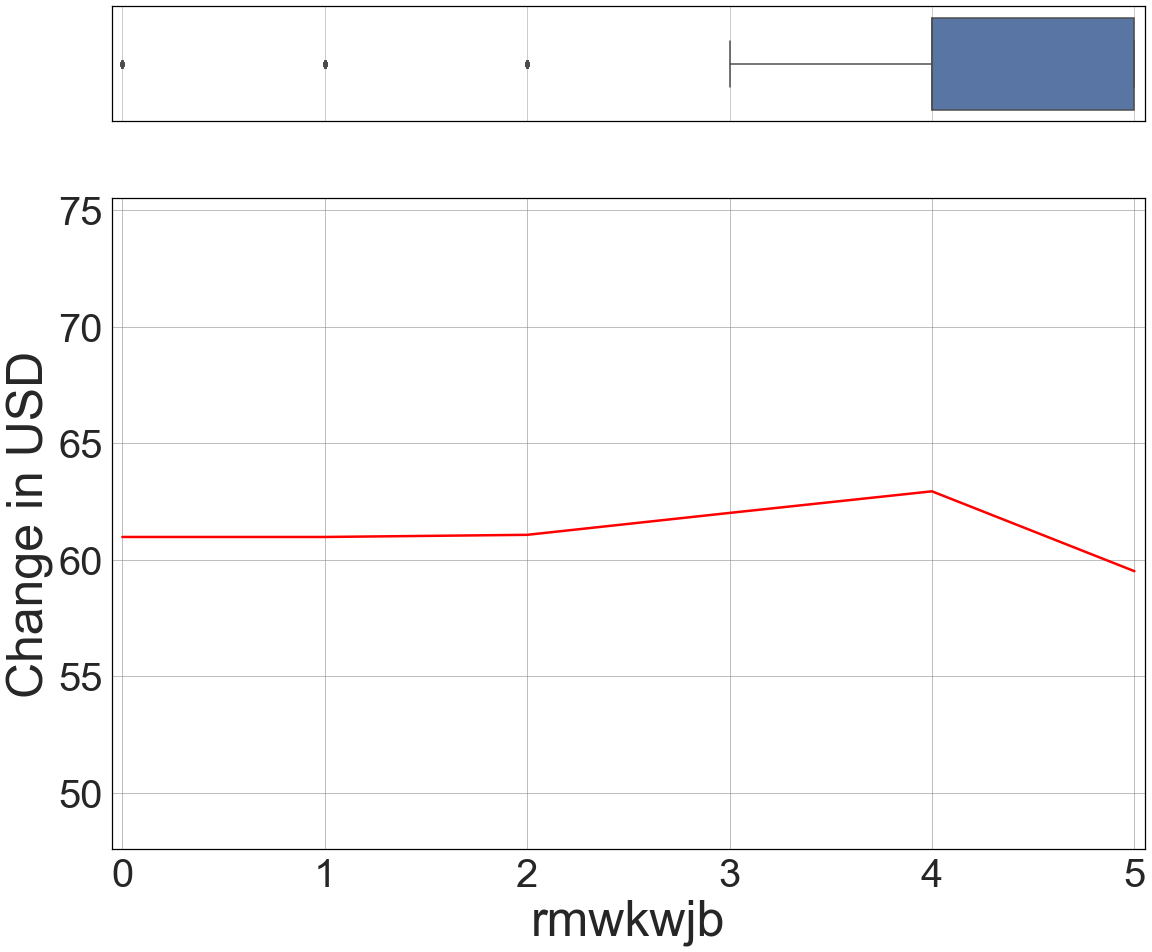

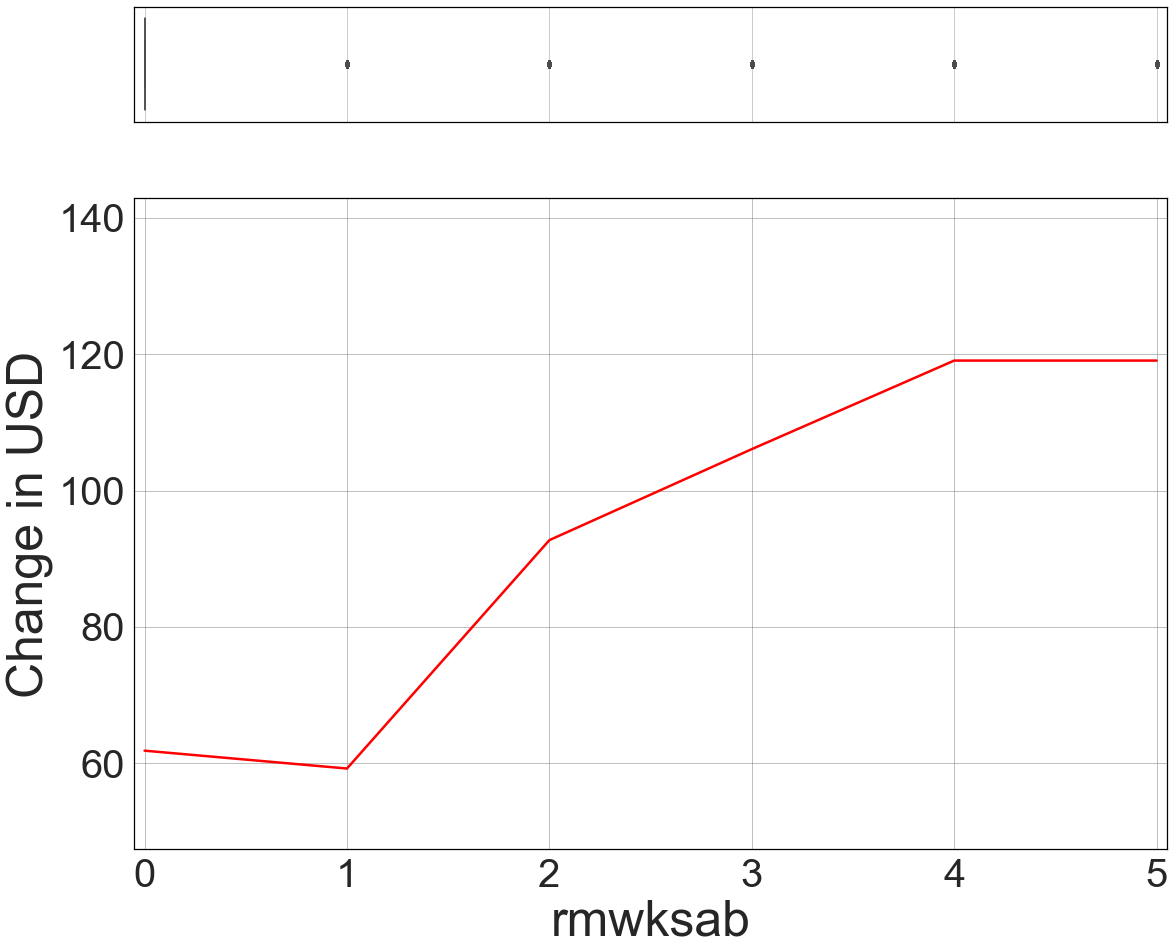

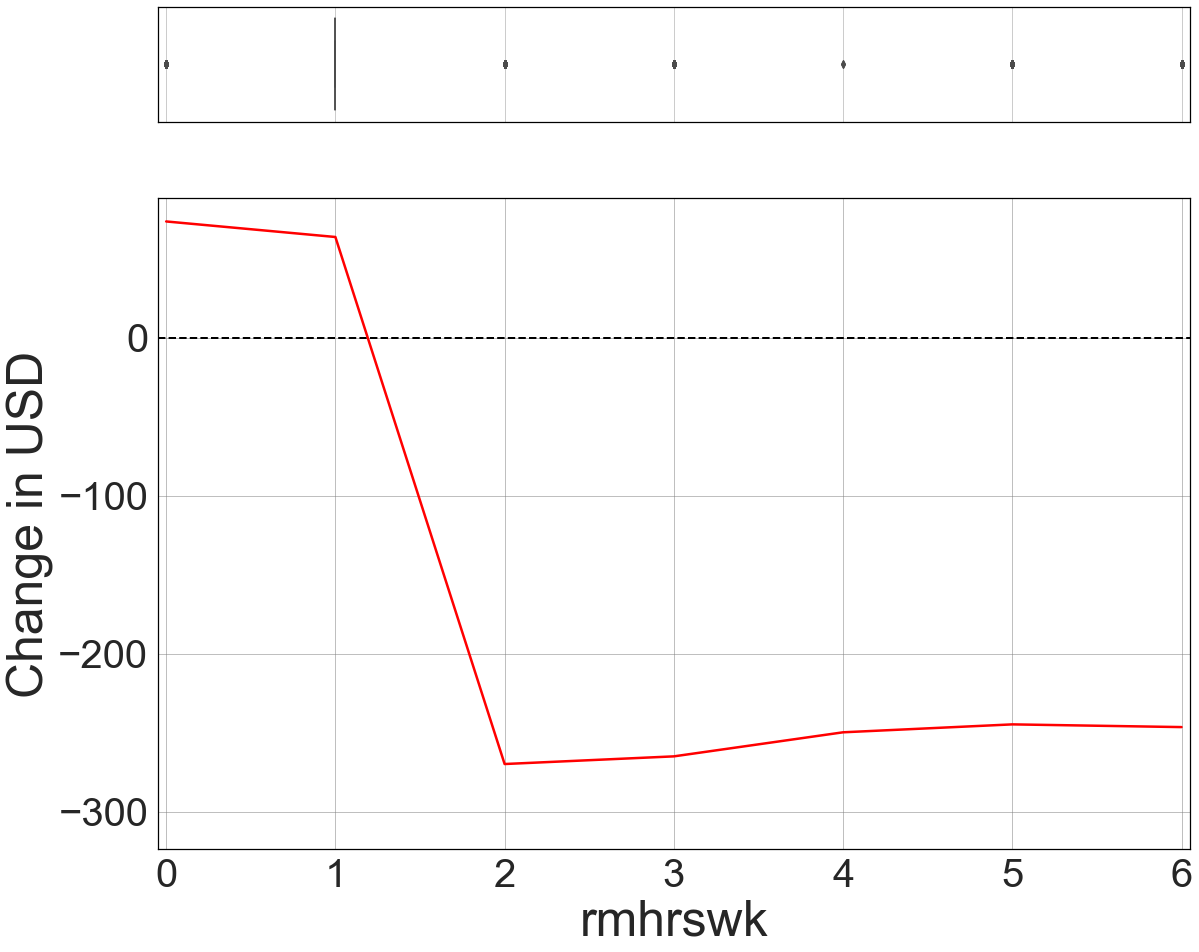

In [28]:
## GET THE PLOTS --- DO NOT CHANGE ANYTHING IN THIS CELL !!!
f_plot = rf_treatment_features_list # Do not change this row !

## Features used for predicting
feature_names = rf_treatment_features_list #rf_features_list_tfearn # Do not change this row ! 
feature_pred = [rf_treatment_features_list.index(x) for x in feature_names] # Do not change this row ! It assures that all the features are used for the prediction.

## Select the forecast models for the treatment and control predictions
model_1 = rf_control
model_2 = rf_treatment

##### Select the dataset for treatment and control predictions
selected_lags = lag_function(lag)

X_1 = np.array(selected_lags[rf_control_features_list])
X_2 = np.array(selected_lags[rf_treatment_features_list])


for i, f in enumerate(chosen_feature):

    x, y_diff_mean, y_diff_median = partial_dependency(model_1, model_2, X_1, X_2, kind, feature_pred, f_plot.index(f))
    
    # Cut the figure window into two parts
    fig, (ax_box, ax_pdp) = plt.subplots(2, sharex = True, gridspec_kw = {'height_ratios': (0.15, 0.85)}, figsize=(18.5, 15.5))
    plt.xticks(fontsize = 40)
    plt.yticks(fontsize = 40)    

    # Add a graph in each part
    sns.boxplot(selected_lags[chosen_feature[i]], ax = ax_box)
    ax_box.set(xlabel = '')
    ax_box.spines['left'].set_color('black')
    ax_box.spines['bottom'].set_color('black')
    ax_box.spines['right'].set_color('black')
    ax_box.spines['top'].set_color('black')
    ax_box.set_facecolor('white')
    
    if measure == 'Mean': 
        target = y_diff_mean
    else: 
        target = y_diff_median
       
    if kind == 'Absolute': 
        unit = 'USD'
        
    else: 
        unit = '%'

    
    
    if len(x) < 5: 
        ax_pdp.plot(x, target, 'o', color = 'red', markersize = 20)
        ax_pdp.hlines(0, xmin = min(x)-0.05, xmax= max(x)+0.05, colors='black', linestyles='--',linewidth=2, alpha=1)
        ax_pdp.axis([min(x)-0.05, max(x)+0.05, min(target)-abs(0.2*min(target)), max(target)+0.2*abs(max(target))])
        ax_pdp.set(xlabel = chosen_feature[i], ylabel = 'Change in '+ str(unit))
        ax_pdp.spines['left'].set_color('black')
        ax_pdp.spines['bottom'].set_color('black')
        ax_pdp.spines['right'].set_color('black')
        ax_pdp.spines['top'].set_color('black')
        ax_pdp.set_facecolor('white')
        ax_pdp.grid(color='grey', linestyle='-', linewidth=0.5, alpha=1)
        ax_pdp.xaxis.label.set_fontsize(50)
        ax_pdp.yaxis.label.set_fontsize(50)
        ax_pdp.tick_params(labelsize=40)
        #fig.suptitle(str(chosen_feature[i]) + ': Partial Dependence Plot', fontsize = 20)
        
    
    else:
        ax_pdp.plot(x, target, '-', color = 'red', linewidth = 2.5)
        ax_pdp.hlines(0, xmin = min(x)-0.05, xmax= max(x)+0.05, colors='black', linestyles='--',linewidth=2, alpha=1)
        ax_pdp.axis([min(x)-0.05, max(x)+0.05, min(target)-abs(0.2*min(target)), max(target)+0.2*abs(max(target))])
        ax_pdp.set(xlabel = chosen_feature[i], ylabel = 'Change in '+ str(unit))
        ax_pdp.spines['left'].set_color('black')
        ax_pdp.spines['bottom'].set_color('black')
        ax_pdp.spines['right'].set_color('black')
        ax_pdp.spines['top'].set_color('black')
        ax_pdp.set_facecolor('white')
        ax_pdp.grid(color='grey', linestyle='-', linewidth=0.5, alpha=1)
        ax_pdp.xaxis.label.set_fontsize(50)
        ax_pdp.yaxis.label.set_fontsize(50)
        ax_pdp.tick_params(labelsize=40)
        #fig.suptitle(str(chosen_feature[i]) + ': Partial Dependence Plot', fontsize = 20)
        
    plt.savefig('Individual ' + str(chosen_feature[i]) +' '+ str(measure)+' ' + str(kind) + ' Lag ' + str(lag) + '.png')

## Partial Dependence Plots for Working Hour Changes

### Single Plots

In [148]:
## Change values only for the variable chosen_feature

kind = 'Marginal' # Absolute, Percentual or Marginal
measure = 'Median' # Mean or Median
lag = [0] # Partial Dependence Plots as defined should only be used for lag 0! This is completely fine, since I focus my 
          # analysis on rebate months only


# Features to select from


#['swave', 'srefmon_numerical','year', 'tage', 'epdjbthn', 'eawop', 'eabre', 'eptwrk', 'eptresn', 'ehrsall', 'tmlmsum',
# 'rmesr','rmwkwjb', 'rmwksab', 'rmhrswk', 'rwksperm', 'epayhr1', 'epayhr2', 'reb_month_numerical', 'rebate_payment',
#'month_numerical', 'ebno1', 'ebno2', 'rf_new', 'famsize', 'spouse', 'flex', 'moonlit', 'selfemp', 'rebate_uplifting',
#'rebate_uplifting_spend', 'rebate_uplifting_save', 'rebate_uplifting_debt']

chosen_feature = 'epayhr1'

In [149]:
## DO NOT CHANGE ANYTHING IN THIS CELL !!!

## Features used for predicting
feature_names = rf_treatment_features_list #rf_features_list_tfearn # Do not change this row ! 
feature_pred = [rf_treatment_features_list.index(x) for x in feature_names] # Do not change this row ! It assures that all the features are used for the prediction.

## Selected feature for the partial dependence dataframe
pd_feature = rf_treatment_features_list.index(chosen_feature) # Do not change this row !

## Select the forecast models for the treatment and control predictions
model_1 = rf_control
model_2 = rf_treatment

## Select the lags
selected_lags = lag_function(lag)

##### Select the dataset for treatment and control predictions
X_1 = np.array(selected_lags[rf_control_features_list])
X_2 = np.array(selected_lags[rf_treatment_features_list])

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:929: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [150]:
## Table with Results

result_table = pdp_hour_df(model_1, model_2, X_1, X_2, feature_pred, pd_feature, kind)
result_table        

,Mean Marginal Working Hour Change,Median Marginal Working Hour Change
epayhr1,,
-1.0,-36.393086,-9.342248
1.0,-41.327853,-12.692154
2.0,36.790568,10.578951


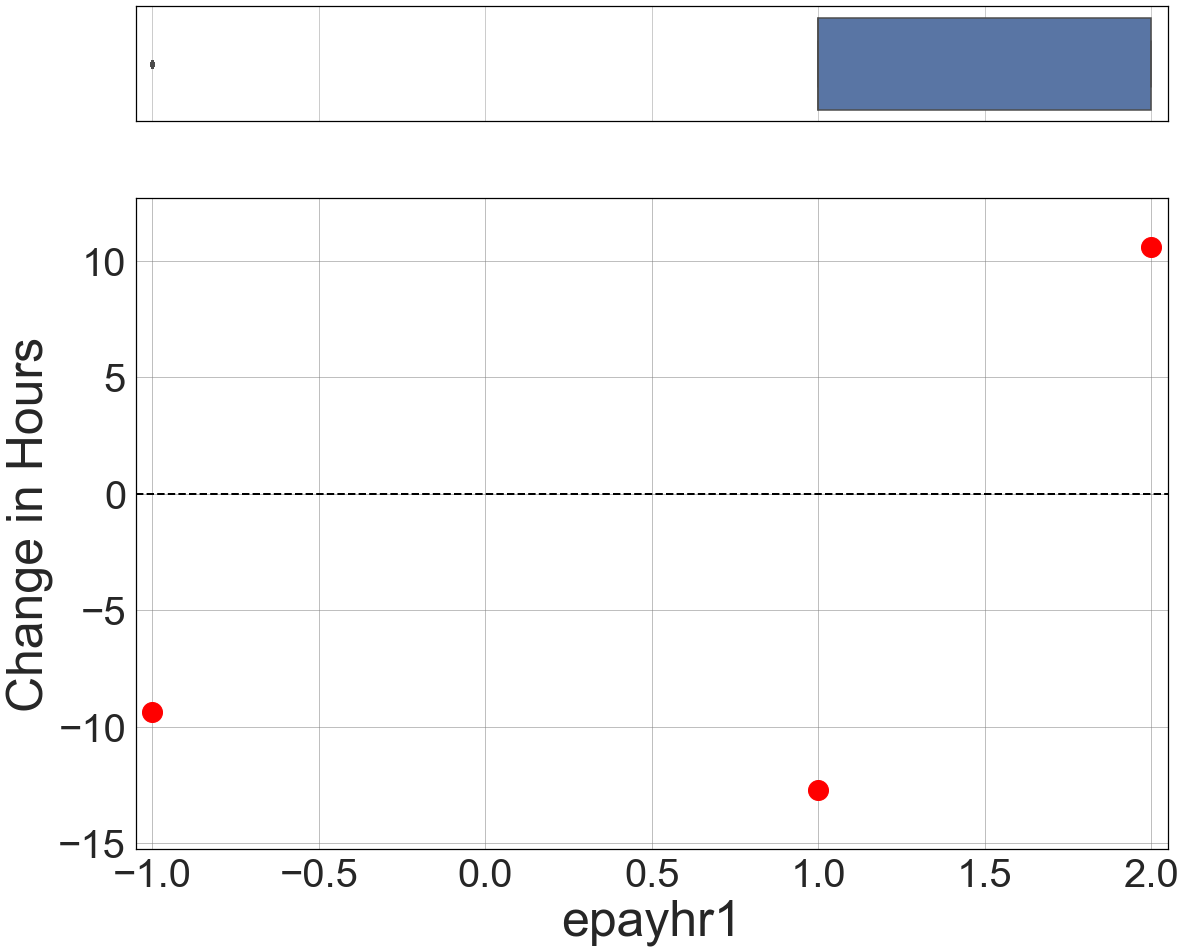

In [151]:
## Plot

df = result_table
measure = 'Median'

pdp_hour_plot(df, measure, kind)

### Multiple Plot

In [166]:
## Change values for kind, measure, the lags and choose the feature for the partial dependency computation

kind = 'Marginal' # Absolute, Percentual or Marginal
measure = 'Mean' # Mean or Median
lag = [0] # Partial Dependence Plots as defined should only be used for lag 0! This is completely fine, since I focus my 
          # analysis on rebate months only



# Features to select from

#['swave', 'srefmon_numerical','year', 'tage', 'epdjbthn', 'eawop', 'eabre', 'eptwrk', 'eptresn', 'ehrsall', 'tmlmsum',
# 'rmesr','rmwkwjb', 'rmwksab', 'rmhrswk', 'rwksperm', 'epayhr1', 'epayhr2', 'reb_month_numerical', 'rebate_payment',
#'month_numerical', 'ebno1', 'ebno2', 'rf_new', 'famsize', 'spouse', 'flex', 'moonlit', 'selfemp', 'rebate_uplifting',
#'rebate_uplifting_spend', 'rebate_uplifting_save', 'rebate_uplifting_debt']

chosen_feature = ['epayhr1', 'ehrsall', 'rmesr', 'eptresn', 'eabre', 'rmwkwjb', 'rmwksab', 'rmhrswk']

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:929: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


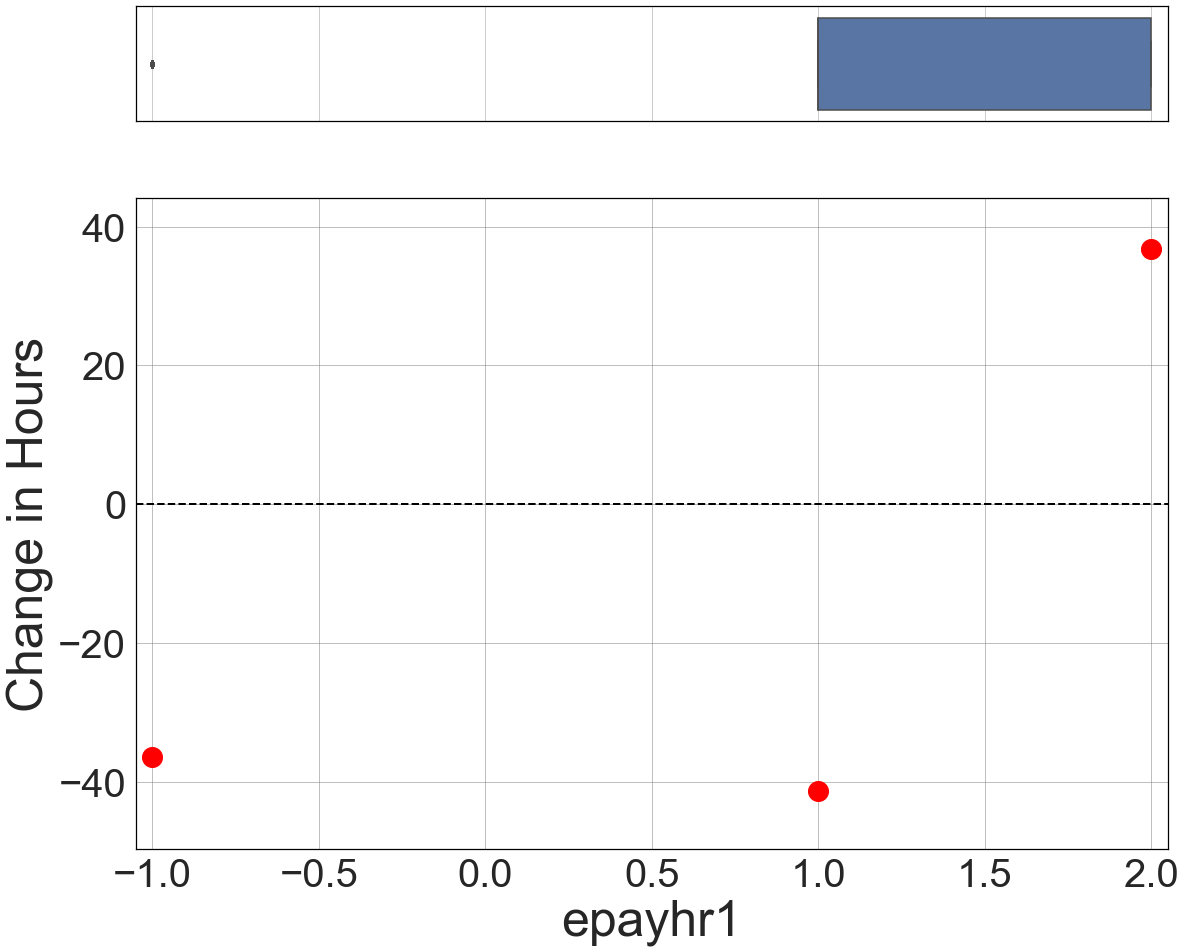

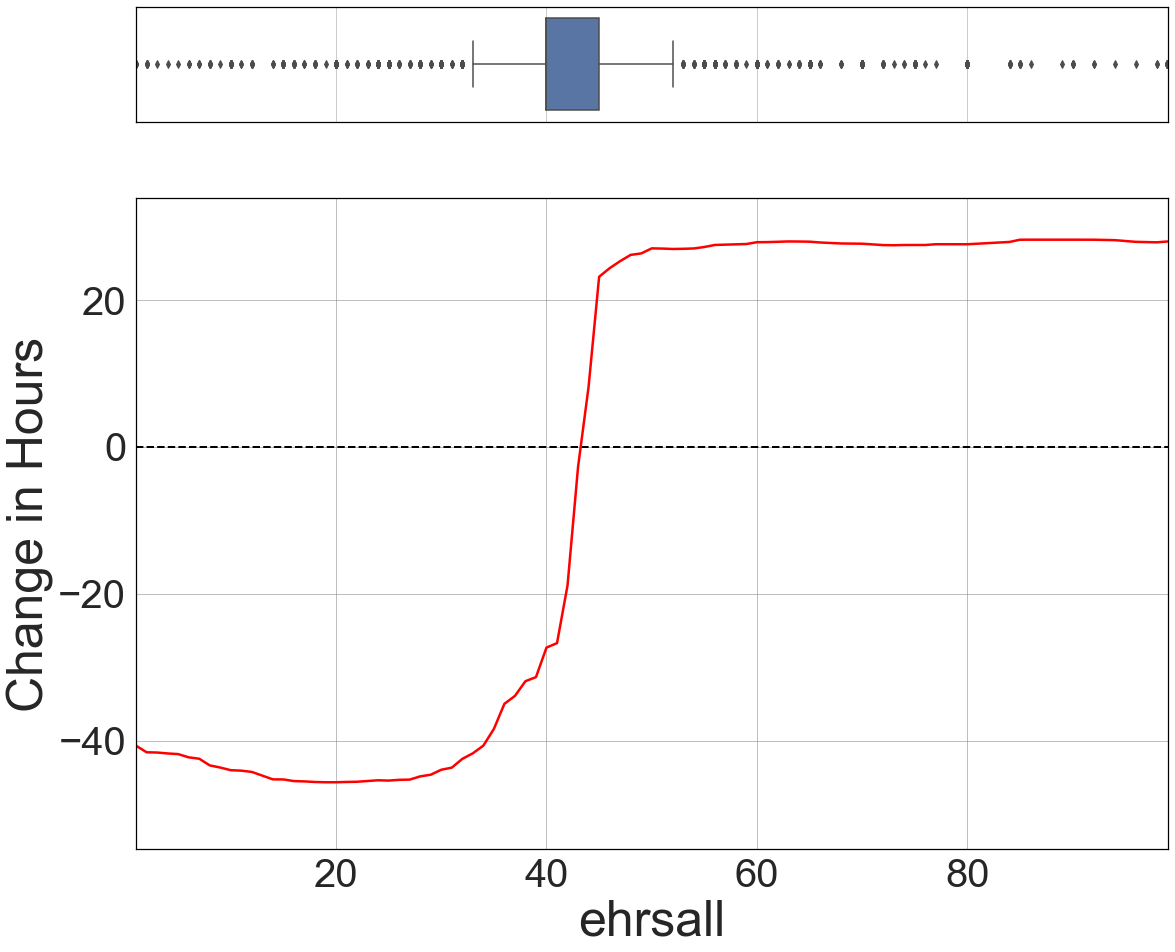

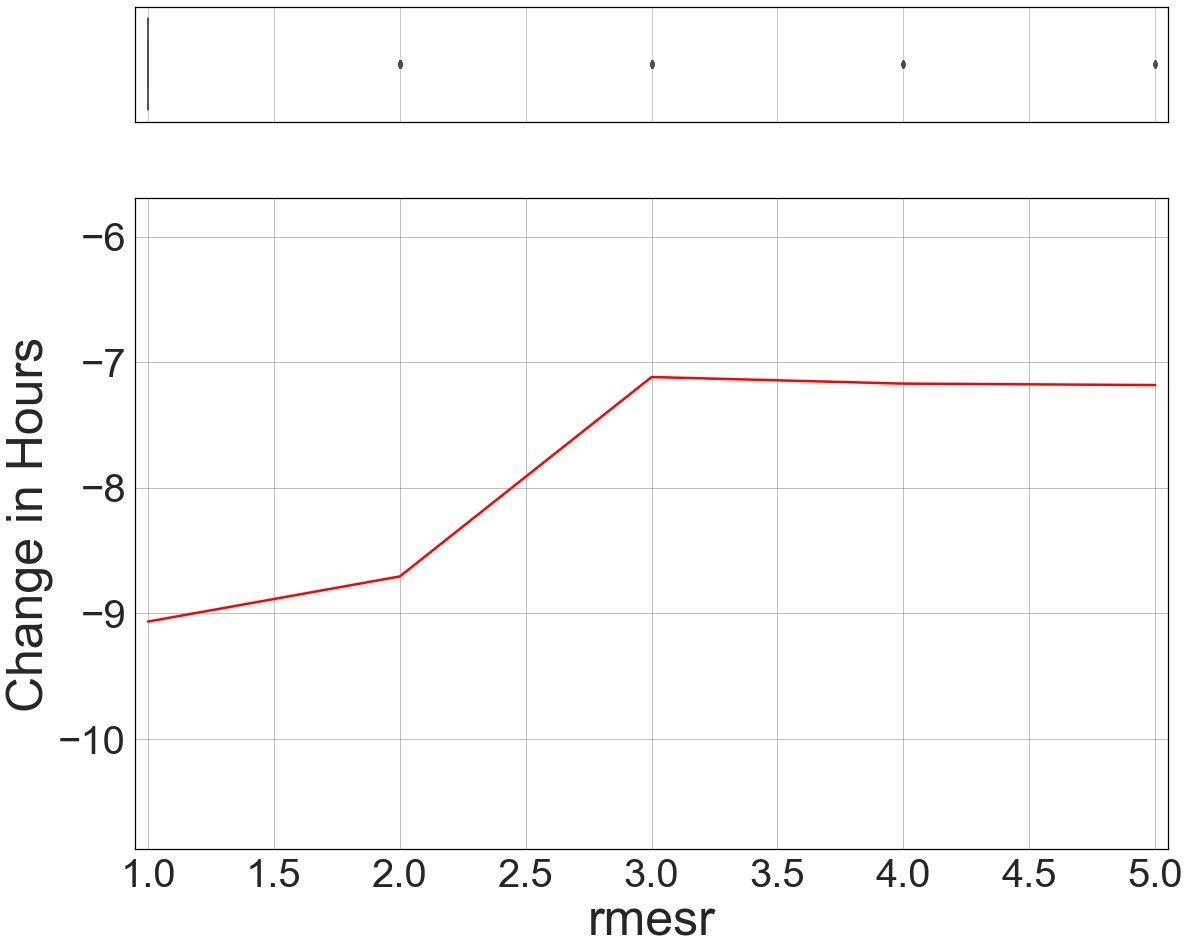

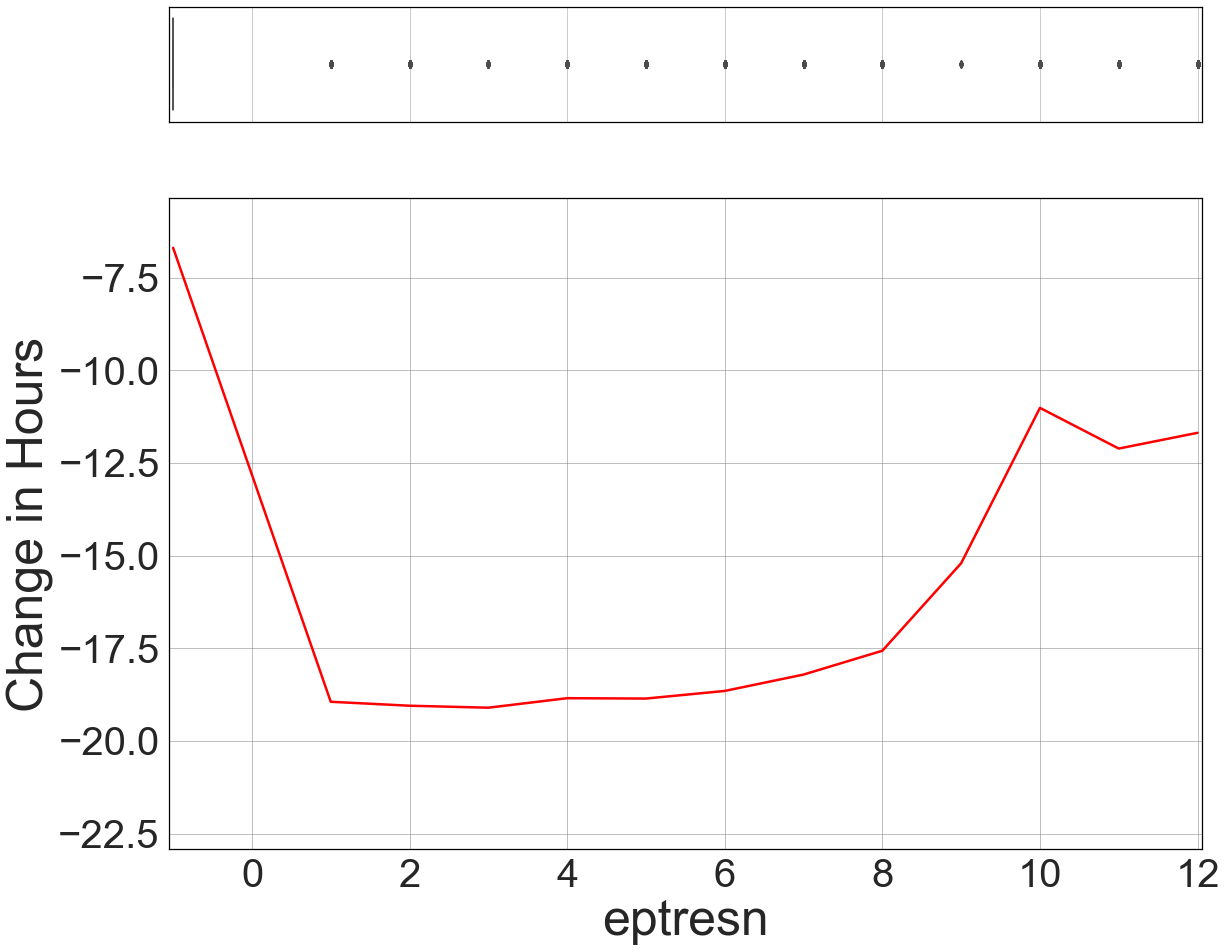

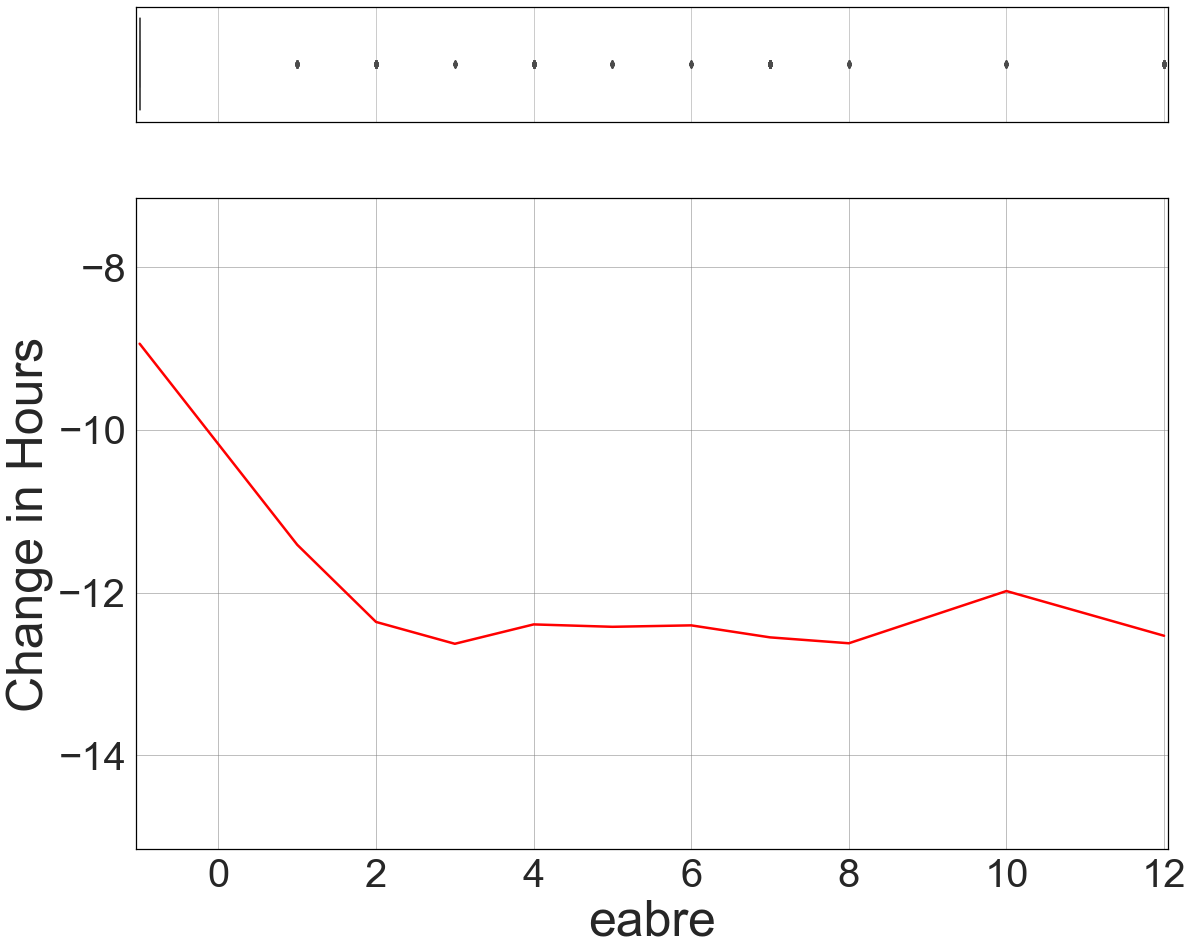

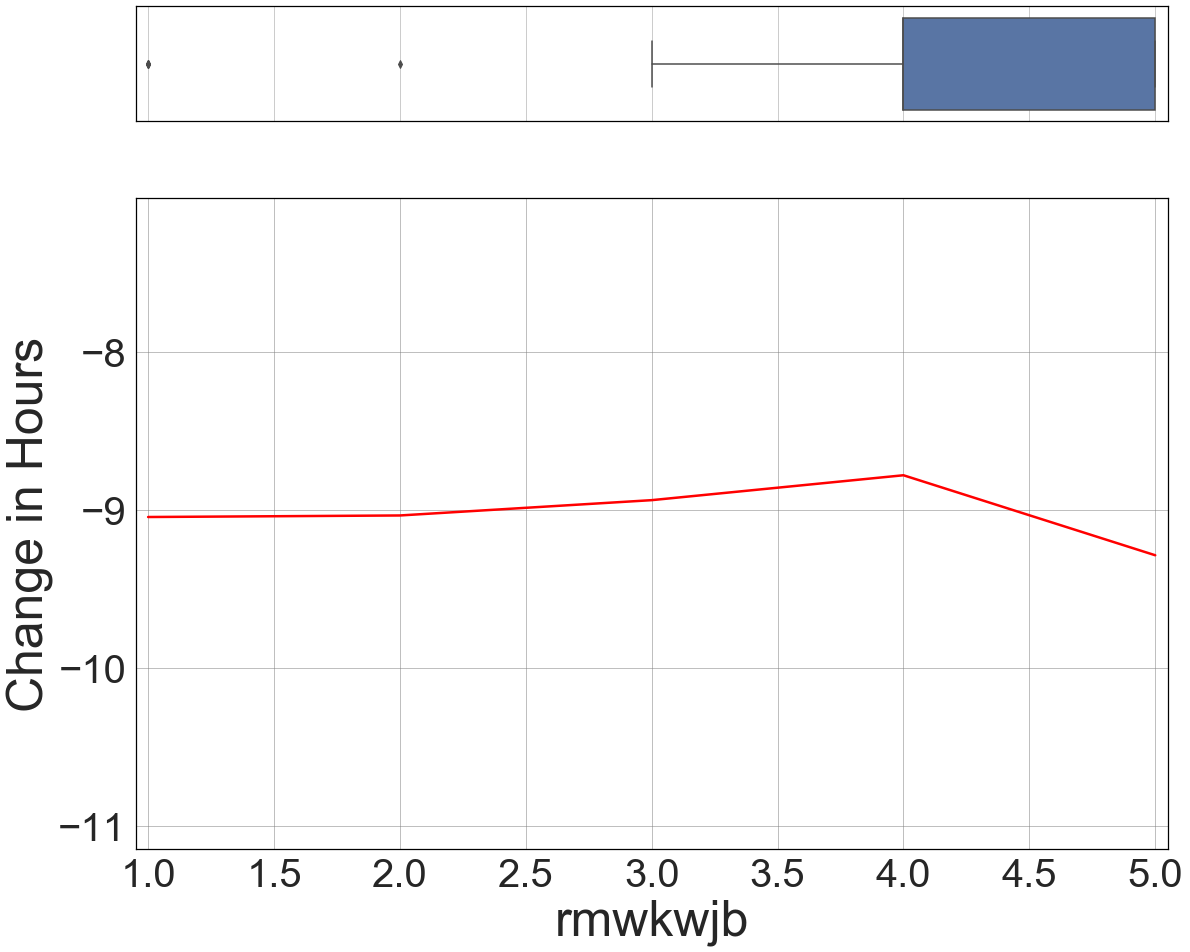

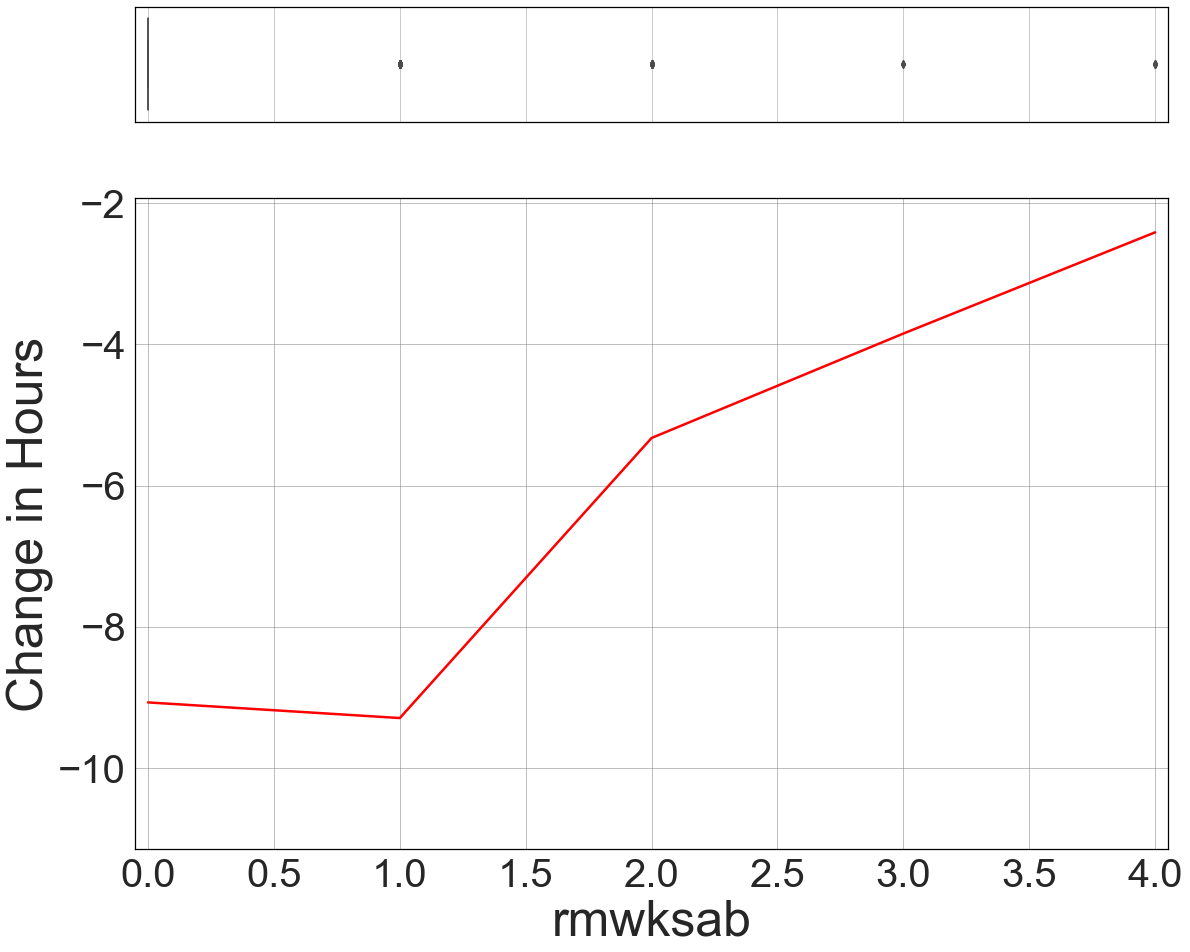

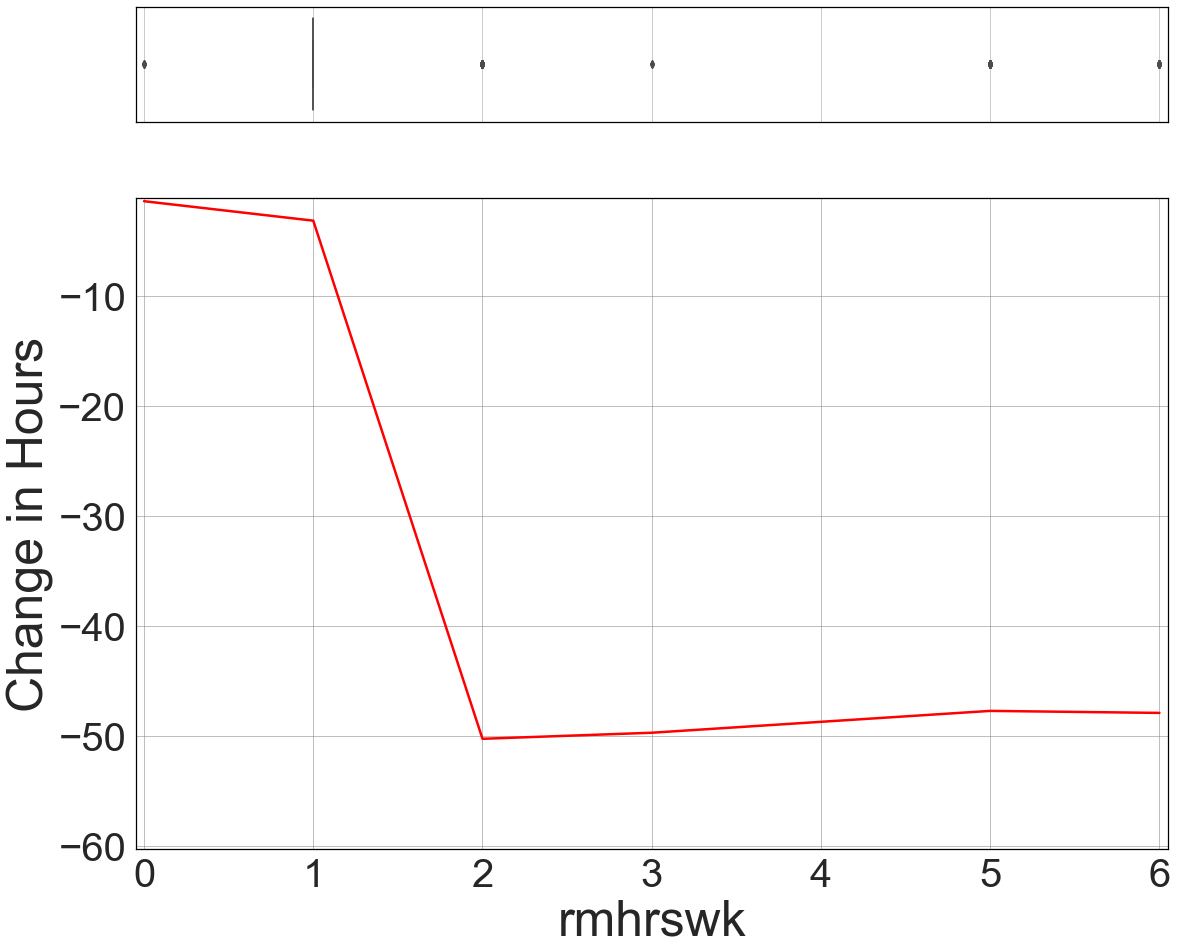

In [167]:
## GET THE PLOTS --- DO NOT CHANGE ANYTHING IN THIS CELL !!!
f_plot = rf_treatment_features_list # Do not change this row !

## Features used for predicting
feature_names = rf_treatment_features_list #rf_features_list_tfearn # Do not change this row ! 
feature_pred = [rf_treatment_features_list.index(x) for x in feature_names] # Do not change this row ! It assures that all the features are used for the prediction.

## Select the forecast models for the treatment and control predictions
model_1 = rf_control
model_2 = rf_treatment

##### Select the dataset for treatment and control predictions
selected_lags = lag_function(lag)

X_1 = np.array(selected_lags[rf_control_features_list])
X_2 = np.array(selected_lags[rf_treatment_features_list])


for i, f in enumerate(chosen_feature):

    x, hours_diff_mean, hours_diff_median = hour_partial_dependency(model_1, model_2, X_1, X_2, kind, feature_pred, f_plot.index(f))
    
    # Cut the figure window into two parts
    fig, (ax_box, ax_pdp) = plt.subplots(2, sharex = True, gridspec_kw = {'height_ratios': (0.15, 0.85)}, figsize=(18.5, 15.5))
    plt.xticks(fontsize = 40)
    plt.yticks(fontsize = 40)    

    # Add a graph in each part
    sns.boxplot(selected_lags[chosen_feature[i]], ax = ax_box)
    ax_box.set(xlabel = '')
    ax_box.spines['left'].set_color('black')
    ax_box.spines['bottom'].set_color('black')
    ax_box.spines['right'].set_color('black')
    ax_box.spines['top'].set_color('black')
    ax_box.set_facecolor('white')
    
    if measure == 'Mean': 
        target = hours_diff_mean
    else: 
        target = hours_diff_median
       
    if kind != 'Percentual': 
        unit = 'Hours'
        
    else: 
        unit = '%' 

    # if kind == 'Percentual': target is the percentage point working hour change compared to 
    # the total working hours of the individual in the observation month

    # if kind == 'Marginal': target is the working hour change for one rebate dollar received
    
    if len(x) < 5: 
        ax_pdp.plot(x, target, 'o', color = 'red', markersize = 20)
        ax_pdp.hlines(0, xmin = min(x)-0.05, xmax= max(x)+0.05, colors='black', linestyles='--',linewidth=2, alpha=1)
        ax_pdp.axis([min(x)-0.05, max(x)+0.05, min(target)-abs(0.2*min(target)), max(target)+0.2*abs(max(target))])
        ax_pdp.set(xlabel = chosen_feature[i], ylabel = 'Change in '+ str(unit))
        ax_pdp.spines['left'].set_color('black')
        ax_pdp.spines['bottom'].set_color('black')
        ax_pdp.spines['right'].set_color('black')
        ax_pdp.spines['top'].set_color('black')
        ax_pdp.set_facecolor('white')
        ax_pdp.grid(color='grey', linestyle='-', linewidth=0.5, alpha=1)
        ax_pdp.xaxis.label.set_fontsize(50)
        ax_pdp.yaxis.label.set_fontsize(50)
        ax_pdp.tick_params(labelsize=40)
        
    
    else:
        ax_pdp.plot(x, target, '-', color = 'red', linewidth = 2.5)
        ax_pdp.hlines(0, xmin = min(x)-0.05, xmax= max(x)+0.05, colors='black', linestyles='--',linewidth=2, alpha=1)
        ax_pdp.axis([min(x)-0.05, max(x)+0.05, min(target)-abs(0.2*min(target)), max(target)+0.2*abs(max(target))])
        ax_pdp.set(xlabel = chosen_feature[i], ylabel = 'Change in '+ str(unit))
        ax_pdp.spines['left'].set_color('black')
        ax_pdp.spines['bottom'].set_color('black')
        ax_pdp.spines['right'].set_color('black')
        ax_pdp.spines['top'].set_color('black')
        ax_pdp.set_facecolor('white')
        ax_pdp.grid(color='grey', linestyle='-', linewidth=0.5, alpha=1)
        ax_pdp.xaxis.label.set_fontsize(50)
        ax_pdp.yaxis.label.set_fontsize(50)
        ax_pdp.tick_params(labelsize=40)
        
    plt.savefig('HOURS Individual ' + str(chosen_feature[i]) +' '+ str(measure)+' ' + str(kind) + ' Lag ' + str(lag) + '.png')

# End